# Swift UVOT Events

## Reading in Data

import the necessary packages, download files, and clean the data.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import Angle, SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries
from astropy.timeseries import BinnedTimeSeries
from astropy.timeseries import aggregate_downsample
from astropy import units as u
from astropy.time import Time
from astropy.time import TimeGPS
from astropy.table import vstack

from regions import CircleSkyRegion
from scipy.optimize import curve_fit
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import wget
import sys

In [2]:
## download the files locally

eventDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/event/sw00094137009um2w1po_uf.evt.gz'
imgDataUrl = 'https://www.swift.ac.uk/archive/reproc/00094137009/uvot/products/sw00094137009u_sk.img.gz'

eventPath = 'sw00094137009um2w1po_uf.evt.gz'
imgPath = 'sw00094137009u_sk.img.gz'

try:
    wget.download(eventDataUrl, eventPath)
    wget.download(imgDataUrl, imgPath)
    print('Downloaded files')
    
except:
    print('Error downloading files')

  0% [                                                    ]    65536 / 79529450Error downloading files


In [3]:
## open files after downloading them locally; no need to change the file path

eventFile = fits.open('sw00094137009um2w1po_uf.evt.gz')
imgFile = fits.open('sw00094137009u_sk.img.gz')

primaryHdu = imgFile[0]
imgHdu = imgFile[1]

wcs = WCS(imgHdu.header)

events = eventFile[1].data

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59236.264051 from DATE-OBS.
Set MJD-END to 59236.548553 from DATE-END'. [astropy.wcs.wcs]


In [4]:
print(events)

[(6.32983520e+08,   1867,   1370, 1916, 1439, 2238, 1547, 1,   0)
 (6.32983520e+08,   1534,   1402, 1593, 1476, 2137, 1857, 1,   0)
 (6.32983520e+08,   2039,   1420, 2079, 1486, 2348, 1419, 1,   0) ...
 (6.33013801e+08,   1164,   1636, 1229, 1718, 2616, 2093, 6, 256)
 (6.33013801e+08,    347,   1727,  432, 1810, 2294, 2827, 6, 256)
 (6.33013801e+08,   1453,   1997, 1503, 2069, 3058, 2034, 6, 256)]


In [5]:
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 116.110733 3.551811 
CRPIX : 1604.5 1583.5 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.000139444442 0.000139444442 
NAXIS : 3208  3166


### Cleaning Event Data

In [6]:
## removing events where the quality is not good, as marked by the telescope
print('cleaning data...')
events_good = events[np.where((events.QUALITY == 0))]
print(f'removed {len(events) - len(events_good)} events')

cleaning data...
removed 1952995 events


In [12]:
## removing non-continuous data points (or floating chunks of data)

print('removing non-continuous data points...')

events_good.sort()
events_int = []
waiting_interval = [tuple(events_good[0])]

formats = events_good.dtype

eStart = events_good['TIME'][0]
eLast = events_good['TIME'][0]

for i in range(1, len(events_good)):
    eTime = events_good['TIME'][i]
    ## belongs to the same interval
    if (eTime - eLast < 5):
        waiting_interval.append(tuple(events_good[i]))
        eLast = eTime
    ## do not belong to the same interval
    else:
        ## save the interval if it is large
        ## if the interval does not have a lot of data, just discard it
        if (eTime - eStart > 80): 
            events_int += waiting_interval
        waiting_interval = []
        eStart = events_good['TIME'][i + 1]
        eLast = events_good['TIME'][i + 1]
        
## dealing with fencepost error 
if (waiting_interval[-1][0] - waiting_interval[0][0] > 80): 
    events_int += waiting_interval
    
## return cleaned events with same formats as original data
events_clean = np.array(events_int, dtype=formats)

removing non-continuous data points...


In [13]:
## convert events to numpy record array

events_clean = events_clean.view(np.recarray)
print('removed', len(events_good) - len(events_clean), 'events')

removed 396177 events


In [631]:
## an interval used for debugging purposes

## middleInterval = events_clean[np.where((events_clean['TIME'] < 633003000) & (events_clean['TIME'] > 633000000))]

## Displaying Event Data

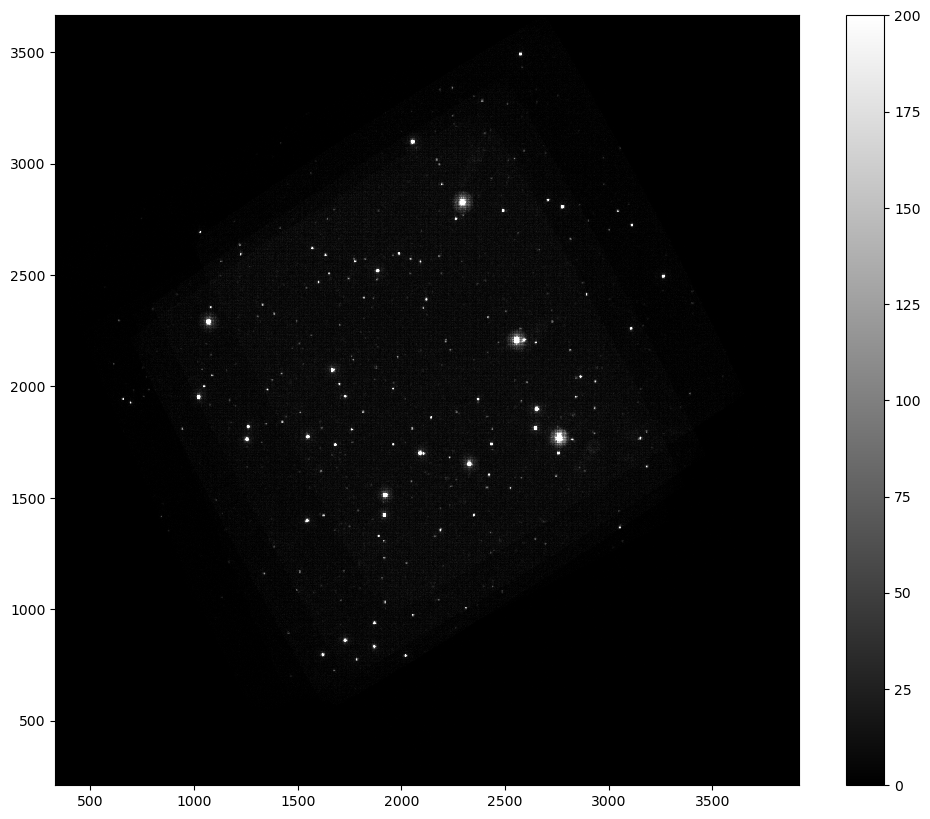

In [14]:
## displays all the data on a 2D histogram

fig, ax = plt.subplots(figsize=(12, 10))

#plt.subplot(projection=wcs)

histdata, x_bins, y_bins, img = plt.hist2d(events_clean.X, events_clean.Y, bins=1000, vmin=0, vmax=200, cmap='gray')
plt.colorbar()
plt.show()

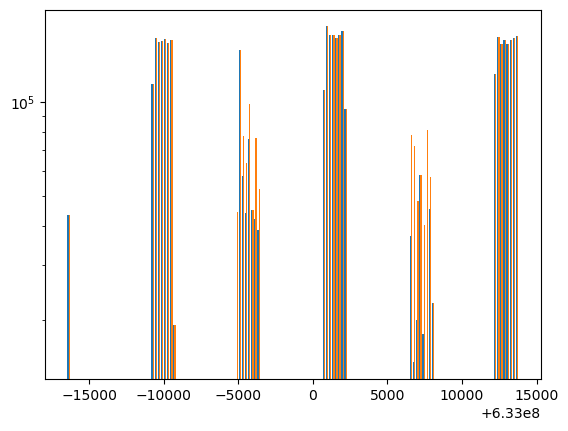

In [15]:
## a histogram of all the cleaned event times (blue) compared to the original event times (orange)
## it makes sense that orange has more data, since some of it is noncontinuous and is discarded

times = plt.hist([events_clean['TIME'], events_good['TIME']], bins='auto', log=True)
plt.show()

## Star-finding

finding stars so their data can be organized

In [16]:
## import annulus
## these stars are smaller, so we use the smaller annulus

print('identifying stars...')

im_frame = Image.open('annuli_imgs/annulus_22.png')

identifying stars...


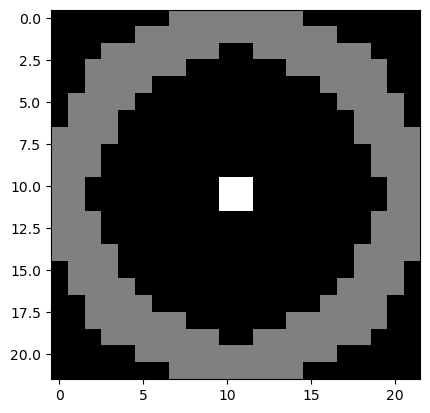

In [17]:
## fix up the imported annulus so that it's a 2D numpy array

np_frame = np.array(im_frame)
annulus_size = len(np_frame)

annulus = np.zeros((annulus_size, annulus_size))
for i in range(annulus_size):
    for j in range(annulus_size):
        ## background (annulus aperture)
        if (np_frame[i, j, 0] == 0 and np_frame[i, j, 3] == 255):
            annulus[i, j] = 1
        ## star (circle aperture)
        elif (np_frame[i, j, 0] == 112):
            annulus[i, j] = 2
            
plt.imshow(annulus, cmap='gray')
plt.show()

### Signal to Noise Ratio

In [68]:
## signal-to-noise ratio function from counting_stars_v5

def calcStarRatio (testImg, x, y):
    ## summing counts

    circle_counts = 0
    annulus_counts = 0
    
    circle_pixels = 0
    annulus_pixels = 0

    for i in range(annulus_size):
        for j in range(annulus_size):
            try:
                if (annulus[i, j] == 2):
                    circle_counts += testImg[i + x, j + y]
                    circle_pixels += 1
                elif (annulus[i, j] == 1):
                    annulus_counts += testImg[i + x, j + y]
                    annulus_pixels += 1
            except:
                pass
                
    ## sky background per pixel (N_s)
    sky_bg_pixel = annulus_counts / annulus_pixels

    ## signal in aperture (N_T)
    signal = (circle_counts - (circle_pixels * annulus_counts / annulus_pixels))
    
    ## total noise = sqrt(N_T + N_s * npix + other stuff (dark current, readout))
    ## mainly what we care about is the background
    total_noise = np.sqrt(signal + (circle_pixels * annulus_counts / annulus_pixels))
    
    ## catch divide-by-zero (preventative)
    if (total_noise == 0):
        total_noise = 1
    
    return signal/total_noise

In [69]:
## calculating SNR for every single pixel on the image
testImg = histdata

snrImg = np.zeros(testImg.shape)
offset = int((annulus_size + 1)/2)
for i in range(-offset, len(testImg) - offset):
    for j in range(-offset, len(testImg[0]) - offset):
        snrImg[i + offset, j + offset] = calcStarRatio(testImg, i, j)

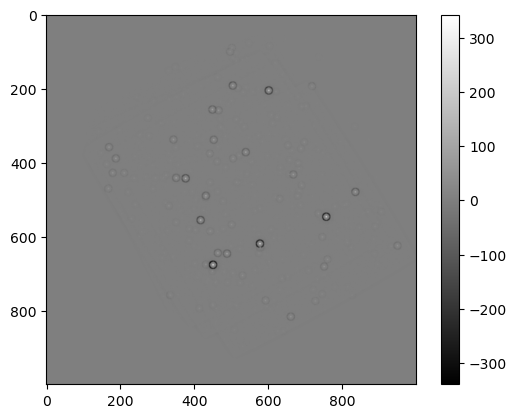

In [70]:
plt.imshow(snrImg, cmap='gray')
plt.colorbar()
plt.show()

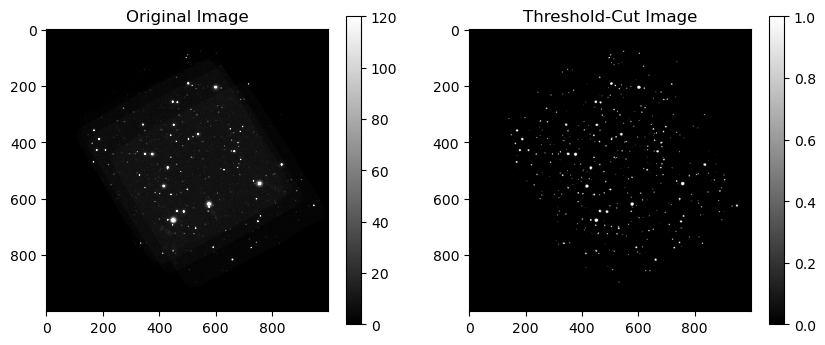

In [20]:
## set a basic threshold for the SNR
threshold = 5

## apply threshold on snrImg
imgCut = np.zeros(snrImg.shape)

for i in range(len(snrImg)):
    for j in range(len(snrImg[0])):
        if (snrImg[i, j] >= threshold):
            imgCut[i, j] = 1
        else:
            imgCut[i, j] = 0

## display the isolated stars 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
originalImg = axes[0].imshow(testImg, cmap='gray', vmin=0, vmax=120)
cutImg = axes[1].imshow(imgCut, cmap='gray')

plt.colorbar(originalImg, ax=axes[0])
plt.colorbar(cutImg, ax=axes[1])

axes[0].set_title('Original Image')
axes[1].set_title('Threshold-Cut Image')

plt.show()

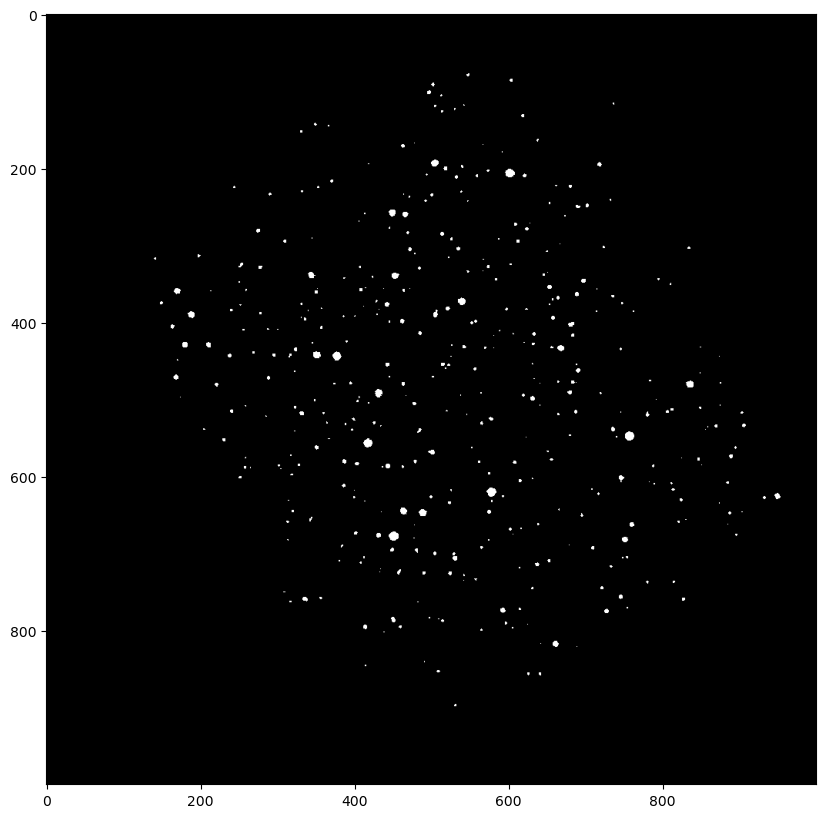

In [22]:

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(imgCut, cmap='gray')
plt.show()

### Counting the Stars

In [23]:
## a simple function that returns if a pixel that's part of a star has a neighbor above and to the left of it

def hasNeighborAbove (matrix, i, j):
    try:
        if (matrix[i - 1][j - 2] or
            matrix[i - 1][j - 1] or
            matrix[i - 1][j] or
            matrix[i - 1][j + 1] or
            matrix[i - 1][j + 2] or
            matrix[i][j - 1]):
            return 0
        else:
            return 1
    except:
        return -1

In [24]:
## a matrix of T/F values for if there is a star at position i,j, where i,j corresponds to its position in testImg.

matrix = [[False for i in range(len(testImg[0]))] for j in range(len(testImg))]

## counting the total number of stars
count = 0

for i in range(len(imgCut)):
    for j in range(len(imgCut[0])):
        if (imgCut[i, j] == 1):
            matrix[i][j] = True
            if (hasNeighborAbove(matrix, i, j) == 1):
                count += 1
        else:
            matrix[i][j] = False

In [25]:
print('number of stars detected in data:', count)

number of stars detected in data: 408


## Star Data
Access stars by coordinates, SNR ratio, and display them by index.

In [26]:
class StarData:
    stars = []
    coords = []
    SNRs = []
    
    ## pass in list of stars, grouped by coordinates
    def __init__ (self, stars):
        self.stars = stars
        self.coords = [[] for _ in range(len(stars))]
        self.SNRs = [0 for _ in range(len(stars))]
        
        for i in range(len(self.stars)):
            xmin, xmax = 1000, 0
            ymin, ymax = 1000, 0
            snrCount = 0
            for [x, y] in self.stars[i]:
                snrCount += snrImg[x, y]
                if (x > xmax): 
                    xmax = x
                elif (x < xmin):
                    xmin = x
                if (y > ymax):
                    ymax = y
                elif (y < ymin):
                    ymin = y
            starX = int((xmax + xmin)/2)
            starY = int((ymin + ymax)/2)
            
            self.coords[i] = [starX, starY]
            
            self.SNRs[i] = snrCount/len(self.stars[i])
    
    ## get all relevant stars within a certain range from specified coordinates
    def getStarByCoord (self, x, y, window=100):
        for i in range(len(self.coords)):
            if (x - window <= self.coords[i][0] <= x + window):
                if (y - window <= self.coords[i][1] <= y + window):
                    print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
    
    ## get all relevant stars by a certain SNR ratio range
    def getStarBySnr (self, minSNR, maxSNR=400):
        for i in range(len(self.SNRs)):
            if (minSNR <= self.SNRs[i] <= maxSNR):
                print('star', i, 'at', self.coords[i], 'with snr', self.SNRs[i])
    
    ## display the selected star by index (accessible by other methods here)
    def displayStar (self, i, size=15, mode='zoom'): ## mode='whole' shows star in context of whole image
        x, y = self.coords[i]
        print(x, y)
        if (mode == 'zoom'):
            plt.imshow(testImg[x - size:x + size, y - size:y + size], vmin=0, vmax=200, cmap='gray')
        else:
            starCircle = plt.Circle((y, x), size, color='y', fill=False)
            plt.imshow(testImg, vmin=0, vmax=200, cmap='gray')
            plt.gca().add_patch(starCircle)
        plt.show()

## Finding the Changing Event

1) Isolate all the coordinates of individual stars.

2) For each star:
    
    a) Get the star data
    
    b) For each possible size of a signal window:
        
        i) For each possible window in the star data:
        
            Calculate the SNR ratio
            
        ii) Return all timestamps with an outlier SNR ratio
        
    c) Return all signal windows with outlier timestamps

### Isolating Stars
Code and helper function to get a list of all the stars, and index contains a list of the coordinates of the star.

In [27]:
## gets all the coordinates for a single star using a floodfill algorithm

def getStar (matrix, i, j):
    ## initial star pixel has coords (i, j)
    star = []
    queue = [[i, j]]
    visited = []
    
    ## floodfill to get the rest of the star
    while (queue != []):
        n1, n2 = queue.pop(0)
        if (matrix[n1][n2] and [n1, n2] not in visited):
            star.append([n1, n2])
            if (n1 > 0 and [n1 - 1, n2] not in visited):
                queue.append([n1 - 1, n2])
            if (n1 < len(matrix) - 2 and [n1 + 1, n2] not in visited):
                queue.append([n1 + 1, n2])
            if (n2 > 0 and [n1, n2 - 1] not in visited):
                queue.append([n1, n2 - 1])
            if (n2 < len(matrix[0]) - 2 and [n1, n2 + 1] not in visited):
                queue.append([n1, n2 + 1])
        
        visited.append([n1, n2])
        
    ## return visited coordinates and all the star coordinates
    return [star, visited]

In [28]:
## get a list of all the stars, which will be used in the next cell to make the total star list (object)

print('saving star information...')

stars = []
visited = []
for i in range(1, len(matrix)):
    for j in range(1, len(matrix[0])):
        if (matrix[i][j] and [i, j] not in visited):
            [star, v] = getStar(matrix, i, j)
            stars.append(star)
            visited += v

saving star information...


In [29]:
## total list of all the stars

starList = StarData(stars)

### Getting Data for a Star

In [30]:
## gets event data for a star based on its coordinates

def getData (star):
    print('getting star data...')
    
    starData = []
    for [s1, s2] in star:
        mask1 = events_clean['X'] >= x_bins[s1]
        filter1 = events_clean[mask1]
        mask2 = filter1['X'] < x_bins[s1 + 1]
        filter2 = filter1[mask2]
        mask3 = filter2['Y'] >= y_bins[s2]
        filter3 = filter2[mask3]
        mask4 = filter3['Y'] < y_bins[s2 + 1]
        filter4 = filter3[mask4]
        
        starData.append(np.array(filter4))
        
    return np.array([d for ls in starData for d in ls])

In [31]:
## timeStamps = True if starData only contains times
## timeStamps = False if starData is actually the list of all the involved event data

def binStarData (starData, timeStamps=True):
    print('binning star data...')
    
    times = [Time(t, format='gps') for t in starData]
    
    ts = TimeSeries(time=times)
    
    ts['num_events'] = [1 for _ in range(len(ts))]
    
    binnedts = aggregate_downsample(ts, time_bin_size=1 * u.second, aggregate_func=np.sum)

    return binnedts

### Other Helper Functions

In [32]:
## visualize the events of a given star
## parameters: binsize (seconds), xmin/xmax (restrict domain), windowStart/Size (for displaying a certain ratio window)
## customLim must be True if xmin/xmax are specified

## displays TS in a plot

def visualizeStarTS (starData, xmin=632980000, xmax=633020000, windowStart=-1, windowSize=-1, customLim=False, point=False):
    print('visualizing time series...')
    
    if (point):
        plt.plot(starData.time_bin_start.gps, starData['num_events'], 'b.')
    else:
        plt.plot(starData.time_bin_start.gps, starData['num_events'], 'b-')
        
    bgWindow = 1.5 * windowSize
    windowDist = 0.2 * windowSize
    
    if (not customLim and windowStart != -1 and windowSize != -1):
        xmin = windowStart - windowDist - bgWindow - windowSize/2
        xmax = windowStart + windowSize + windowDist + bgWindow + windowSize/2
    
    plt.xlim(xmin, xmax)
    
    ## draw window
    if (windowStart != -1 and windowSize != -1):
        
        plt.axvspan(windowStart, windowStart + windowSize, color='g', alpha=0.5, lw=0)
        
        plt.axvspan(windowStart - windowDist - bgWindow, windowStart - windowDist, color='r', alpha=0.5, lw=0)
        plt.axvspan(windowStart + windowSize + windowDist, windowStart + windowSize + windowDist + bgWindow, 
                    color='r', alpha=0.5, lw=0)
        
    plt.xlabel("Time (s)")    
    plt.ylabel("Photon Rate (count/s)")
        
    plt.show()
    
    bounds = np.where((starData['time_bin_start'].value >= xmin) & (starData['time_bin_start'].value <= xmax))
    
    return starData[bounds]

In [33]:
## split mass of data into contiguous intervals
## returns list of [i, j] where starData[i] is the beginning of the interval and starData[j] is the end

## FUNCTION IS NO LONGER IN USE AS OF 7.25.24

def splitInterval (starData, windowLength=5):
    intervals = []
    intLeft = 0
    intRight = 0
    for i in range(1, len(starData)):
        if (type(starData[i]['num_events']) == np.ma.core.MaskedConstant):
            if (intRight - intLeft > 0):
                dist = (starData['time_bin_start'][intRight].value - starData['time_bin_start'][intLeft].value) #* (24 * 3600)
                if (dist >= windowLength * 3.5):
                    intervals.append([intLeft, intRight])
            intLeft = i
            intRight = i
        else:
            intRight = i
            
    ## dealing with fencepost error
    dist = starData['time_bin_start'][intRight].value - starData['time_bin_start'][intLeft].value
    if (dist >= windowLength * 3.5 and 
        len(starData['time_bin_start'][intLeft : intRight + 1]) > windowLength * 3.5):
        intervals.append([intLeft, intRight])
    
    return intervals

In [34]:
## returns the max window size that can be analyzed when calculating ratios, avoiding high outliers

## FUNCTION NO LONGER IN USE AS OF 07.26.2024

def getMaxWindow (starData):
    try:
        ints = splitInterval(starData, 5)
        mins = [min(1000000, starData[ints[i][1]]['time_bin_start'].value - starData[ints[i][0]]['time_bin_start'].value) for i in range(len(ints))]
        return int(max(mins) / 4)
    except:
        return 0

### Calculating SNR Ratio
Input: window size, beginning of signal window timestamp, sorted star data

Output: signal to noise ratio

Guaranteed: beginning of signal window timestamp is inside the sorted star data

In [35]:
## calculates the signal-to-noise ratio for a given interval

def calculateRatio (signalWindow, timeStart, starData, printLog=False):
    ## calculate background window size
    bgWindow = 1.5 * signalWindow ## bgWindow is 1.5 * len(signalWindow) on both sides
    windowDist = 0.2 * signalWindow ## distance between bgWindow and signalWindow
    bgArea = 0
    
    ## adding up photon counts
    # signal
    sigEvents = starData[np.where((starData['time_bin_start'].value >= timeStart) & 
                                  (starData['time_bin_start'].value < timeStart + signalWindow))]
    signalCounts = np.sum(sigEvents['num_events'].compressed())
    
    if (signalCounts == 0):
        return 'pass'
    
    # background
    leftBg = starData[np.where((starData['time_bin_start'].value >= timeStart - bgWindow - windowDist) & 
                               (starData['time_bin_start'].value < timeStart - windowDist))]
     
    rightBg = starData[np.where((starData['time_bin_start'].value >= timeStart + signalWindow + windowDist) & 
                               (starData['time_bin_start'].value < timeStart + signalWindow + bgWindow + windowDist))]
    
    ## area of bg window
    leftArea = min(len(np.where(leftBg['num_events'] > 0)[0]), bgWindow)
    rightArea = min(len(np.where(rightBg['num_events'] > 0)[0]), bgWindow) 
    
    if (leftArea == 0 or rightArea == 0):
        return 'pass'
    
    bgArea += leftArea + rightArea
    
    ## photon counts  
    bgCounts = np.sum(leftBg['num_events']) + np.sum(rightBg['num_events'])
    bgEvents = np.append(leftBg['num_events'].compressed(), rightBg['num_events'].compressed())

    ## calculating noise
    bgMeanRate = bgCounts/bgArea
    signalRate = signalCounts/signalWindow - bgMeanRate
    totalNoiseRate = np.std(bgEvents)
    
    ## debugging
    if (printLog):
        print('bgEvents', bgEvents)
        print('signalCounts', signalCounts, 'signalArea', signalWindow)
        print('bgCounts', bgCounts, 'bgArea', bgArea)
        print('bgMeanRate', bgMeanRate, 'signalRate', signalRate, 'totalNoiseRate', totalNoiseRate)
    
    ## catch divide-by-0 error (preventative)
    if (totalNoiseRate <= 0):
        totalNoiseRate = 1
        
    return signalRate/totalNoiseRate

### Finding Interesting Signals for Each Star
Input: signal window, sorted star event data

Output: list of S/N ratios, measured timestamps

Outlier threshold: mean + 4 * SD

In [36]:
## define a gaussian distribution function for fitting purposes

def gaussian (x, a, mean, sigma):
    return a * np.exp(-((x-mean)**2)/(2*sigma**2))

In [37]:
## get all the signal-to-noise ratios for a star, with a certain signal window

def getSignals (signalWindow, starData, printLog=False):
    ratios = []
    measuredTimestamps = []
    
    ## iterate through every entry in starData, and calculate the SNR ratio
    for s in starData[:-int(signalWindow)]:
        ratio = calculateRatio(signalWindow, s['time_bin_start'].value, starData, printLog)
        if (ratio != 'pass'):
            measuredTimestamps.append(s['time_bin_start'].value)
            ratios.append(ratio)
    
    ## returns the SNRs and all their timestamps, where ratios[i] corresponds to measuredTimestamps[i]
    return ratios, measuredTimestamps

In [38]:
## visualizes the SNRs in a histogram

def visualizeSignals (ratios, numBins):
    ratio_n, ratio_bins, _ = plt.hist(ratios, bins=numBins, log=True)
    x = np.linspace(min(ratios), max(ratios), numBins)
    y = ratio_n

    ## attempts to fit a curve onto the plot
    try:
        popt, pcov = curve_fit(gaussian, x, y)
        plt.plot(x, gaussian(x, *popt), c='r')

        plt.axis([min(ratios) - 1, max(ratios) + 1, 0.5, max(ratio_n) + 100])

        ## fit parameters

        amp, mean, stdev = popt
        print('amp', amp, 'mean', mean, 'stdev', stdev)

        threshold = mean + 5 * abs(stdev)
        plt.axvline(x=threshold, c='g', linewidth=1)
      
    ## small and not-ideal workaround
    except Exception as error:
        print(error)
        mean = np.mean(ratios)
        stdev = np.std(ratios)
        threshold = mean + 5 * stdev
    
    plt.xlabel("SNR Ratio")
    plt.ylabel("Frequency")
    
    plt.show()
    
    return mean, abs(stdev), threshold

In [39]:
## gets all the timestamps where the SNR is an outlier

def getOutlierTimestamps (ratios, measuredTimestamps, threshold=5):
    outlierTimestamps = []
    for i in range(len(ratios)):
        if (ratios[i] > threshold):
            outlierTimestamps.append(measuredTimestamps[i])
            
    return outlierTimestamps

In [40]:
## gets the relevant info about a certain SNR
## input ratios and measured times, and if it is to the left of the curve (True) or to the right (False)
## returns all relevant timestamps with ratio toward that extreme

def unusualSignalInfo (ratios, measuredTimes, ratioEstimate, left=False):
    for i in range(len(ratios)):
        if (not left and ratios[i] > ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
        if (left and ratios[i] < ratioEstimate):
            print('index', i, 'with ratio', ratios[i], 'at time', measuredTimes[i])
    return

### Iterating over Signal Window Size

In [41]:
## iterates over different signal window sizes for a given star
## input: star data
## output: dictionary of outlier timestamps for each signal window

def analyzeStar (starData):
    outlierWindows = {}
    
    minWindow = 5
    maxWindow = 6
    
    ## for i in range(minWindow, maxWindow):
    for i in [5, 10]:
        print('window', i)
        ratios, measuredTimestamps = getSignals(i, starData)
        mean, stdev, threshold = visualizeSignals(ratios, 100)
        print(mean, stdev, threshold)
        
        ## not sure if I want outliers for now
#         outliers = getOutlierTimestamps(ratios, measuredTimestamps, threshold)
    
#         if (outliers != []):
#             outlierWindows[i] = outliers
            
#     return outlierWindows.keys()
    
    return

### Iterating over Stars

next: 0
next: 1
next: 2
next: 3
next: 4
next: 5
next: 6
next: 7
next: 8
next: 9
next: 10
next: 11
next: 12
next: 13
next: 14
next: 15
next: 16
next: 17
next: 18
next: 19
window 5
amp 176.6445809037249 mean -0.12166340368703155 stdev 0.5569758701357118


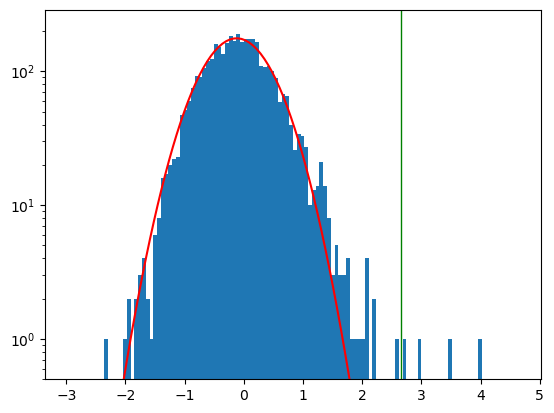

-0.12166340368703155 0.5569758701357118 2.6632159469915275
window 10
amp 162.40395985539604 mean 0.0011438494956921984 stdev 0.3975331278194988


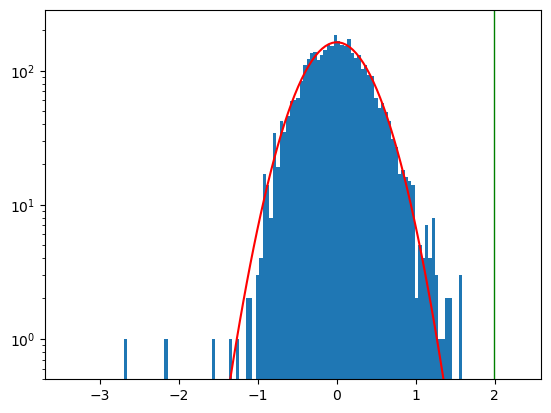

0.0011438494956921984 0.3975331278194988 1.988809488593186
None
next: 20
next: 21
next: 22
next: 23
next: 24
window 5
amp 127.6412251972116 mean -0.191081890430117 stdev -0.5755449718083153


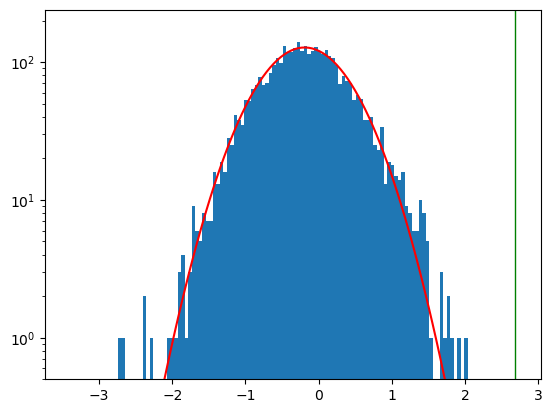

-0.191081890430117 0.5755449718083153 2.68664296861146
window 10
amp 100.07639725445625 mean -0.0004946168337399328 stdev 0.40291272298458963


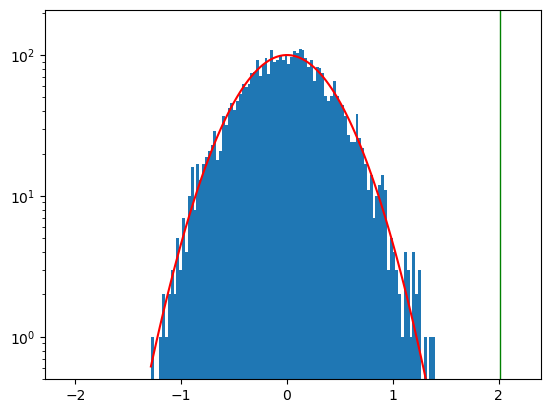

-0.0004946168337399328 0.40291272298458963 2.014068998089208
None
next: 25
next: 26
next: 27
next: 28
next: 29
next: 30
next: 31
next: 32
next: 33
next: 34
next: 35
next: 36
next: 37
next: 38
next: 39
next: 40
next: 41
next: 42
next: 43
next: 44
next: 45
next: 46
next: 47
window 5
amp 176.90015822950824 mean -0.11918879047496063 stdev -0.5623528141496159


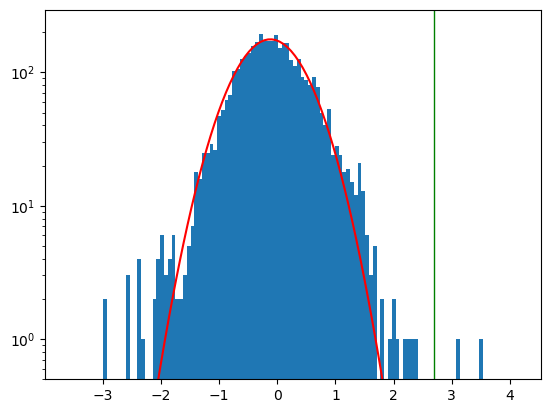

-0.11918879047496063 0.5623528141496159 2.692575280273119
window 10
amp 183.9968646017336 mean -0.005210410131948726 stdev 0.3606035837806568


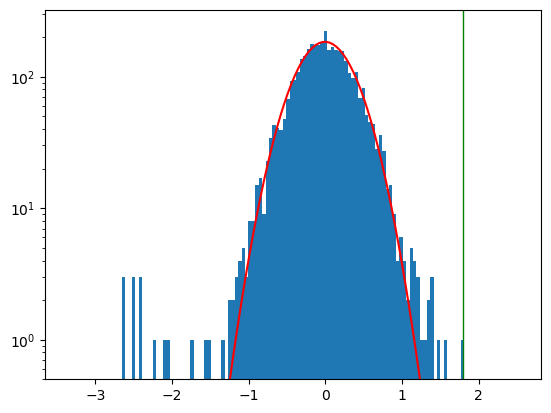

-0.005210410131948726 0.3606035837806568 1.7978075087713354
None
next: 48
window 5
amp 146.77793861100008 mean -0.2751179623223849 stdev 0.6171824870757188


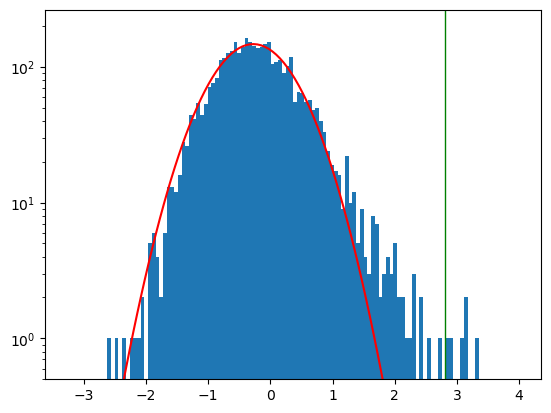

-0.2751179623223849 0.6171824870757188 2.8107944730562093
window 10
amp 107.55263858872449 mean -0.20035851627903659 stdev 0.41767099424292453


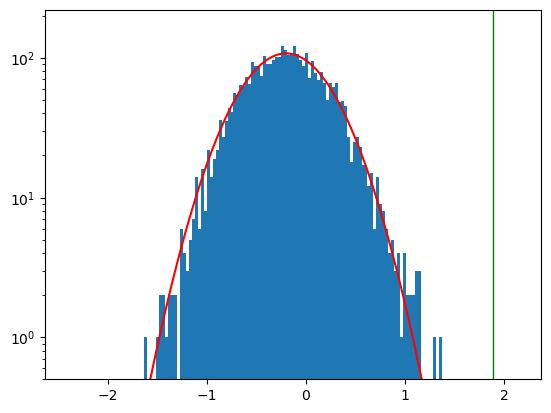

-0.20035851627903659 0.41767099424292453 1.887996454935586
None
next: 49
next: 50
next: 51
next: 52
next: 53
next: 54
next: 55
next: 56
next: 57
next: 58
next: 59
next: 60
next: 61
next: 62
next: 63
next: 64
next: 65
next: 66
next: 67
next: 68
next: 69
next: 70
next: 71
next: 72
next: 73
next: 74
next: 75
next: 76
next: 77
next: 78
next: 79
next: 80
next: 81
next: 82
next: 83
window 5
amp 153.3560764764861 mean -0.20015908348790382 stdev 0.5716411254300073


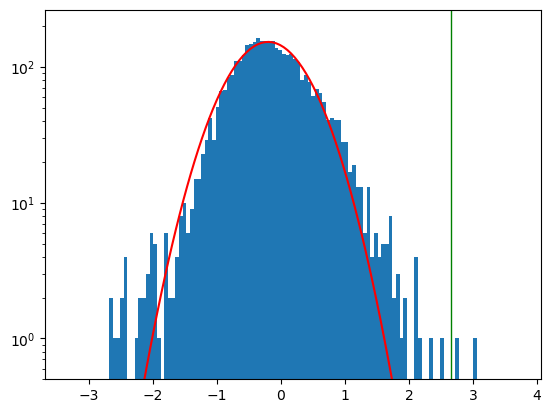

-0.20015908348790382 0.5716411254300073 2.6580465436621328
window 10
amp 153.0791959791728 mean -0.10925101766453545 stdev 0.39476082632294796


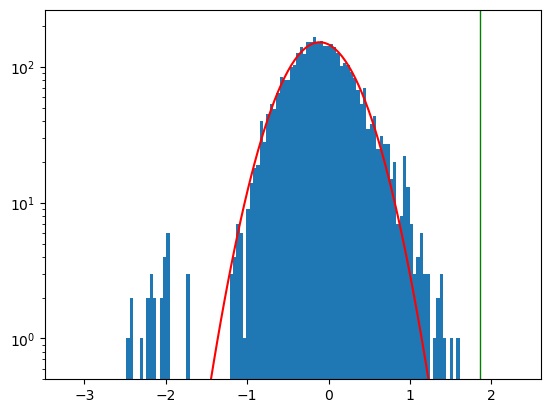

-0.10925101766453545 0.39476082632294796 1.8645531139502045
None
next: 84
next: 85
window 5
amp 211.4274391987238 mean -0.1614356971359854 stdev 0.5453577925118955


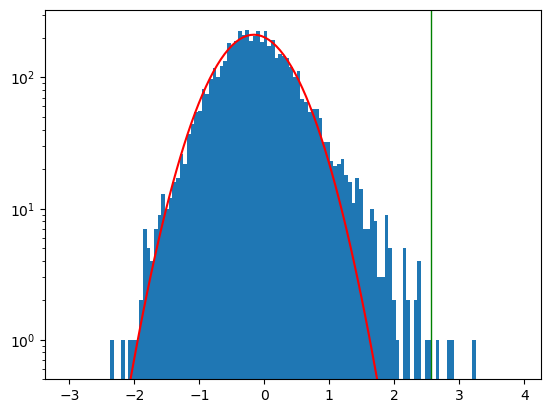

-0.1614356971359854 0.5453577925118955 2.565353265423492
window 10
amp 164.05219497687128 mean -0.06561276919786371 stdev 0.3912053513843979


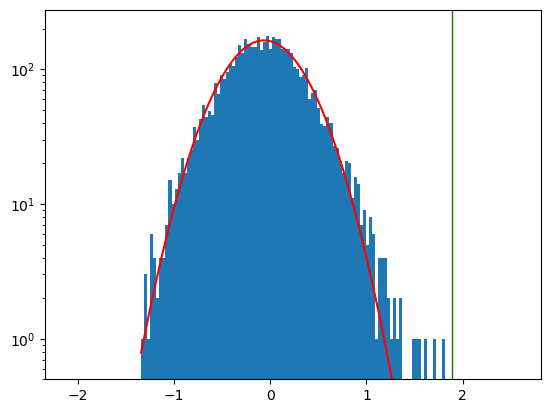

-0.06561276919786371 0.3912053513843979 1.8904139877241257
None
next: 86
next: 87
next: 88
next: 89
next: 90
next: 91
next: 92
next: 93
next: 94
next: 95
next: 96
window 5
amp 71.74811478135535 mean -0.12733202653839323 stdev 0.5512661516656704


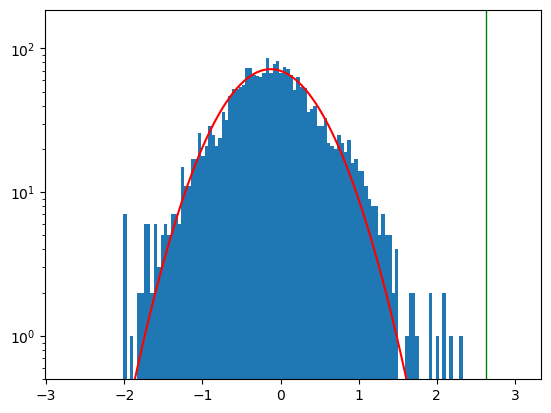

-0.12733202653839323 0.5512661516656704 2.6289987317899586
window 10
amp 65.20213102873468 mean -0.06808399832327623 stdev 0.4173654402330003


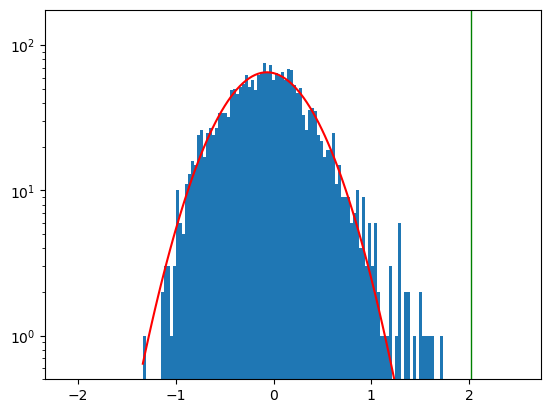

-0.06808399832327623 0.4173654402330003 2.0187432028417254
None
next: 97
next: 98
next: 99
next: 100
next: 101
next: 102
next: 103
next: 104
next: 105
next: 106
next: 107
next: 108
next: 109
window 5
amp 254.09082116850408 mean -0.20977790909377567 stdev 0.5858752800593191


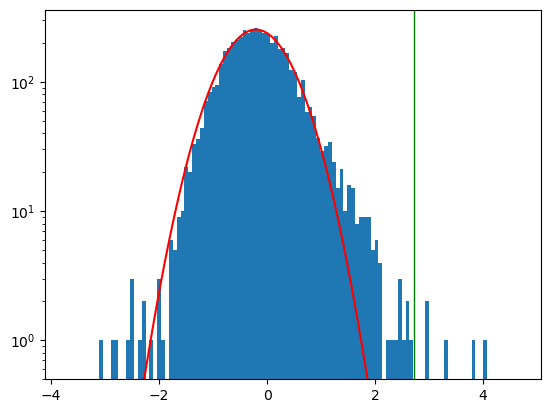

-0.20977790909377567 0.5858752800593191 2.7195984912028197
window 10
amp 281.2357694041966 mean -0.13078560173891435 stdev 0.40695619097699376


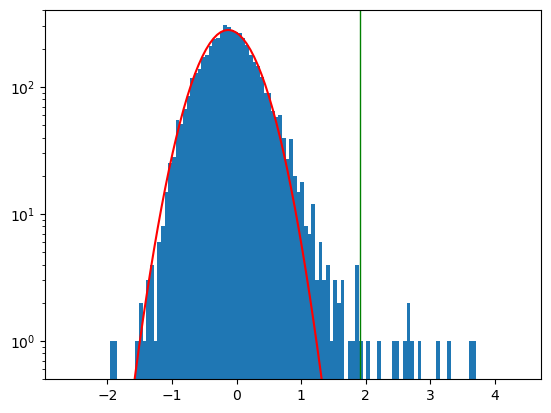

-0.13078560173891435 0.40695619097699376 1.9039953531460545
None
next: 110
next: 111
next: 112
next: 113
window 5
amp 210.38748962342544 mean -0.9903852931446236 stdev 0.6978687363164462


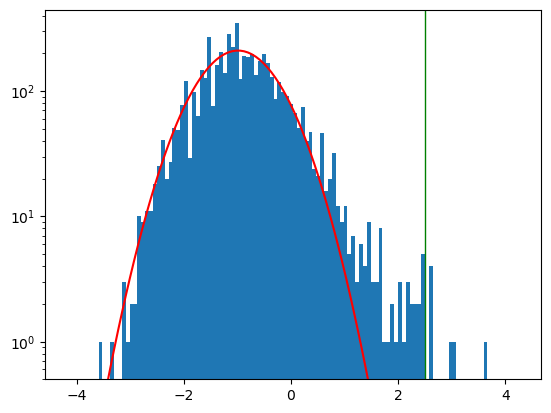

-0.9903852931446236 0.6978687363164462 2.4989583884376074
window 10
amp 196.65468528721058 mean -0.9005343774699358 stdev -0.46805243366253096


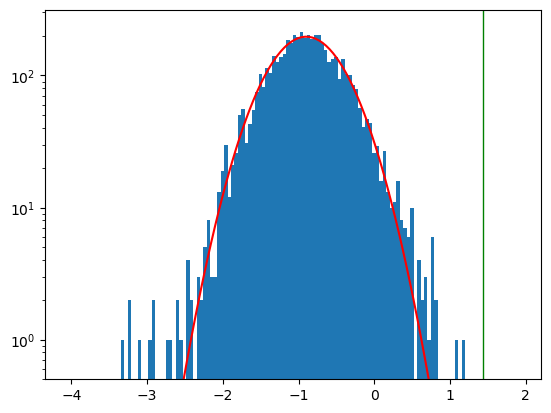

-0.9005343774699358 0.46805243366253096 1.4397277908427193
None
next: 114
next: 115
next: 116
next: 117
next: 118
next: 119
next: 120
next: 121
next: 122
next: 123
next: 124
next: 125
next: 126
window 5
amp 192.73473523228932 mean -0.8017334060780876 stdev 0.665403244053152


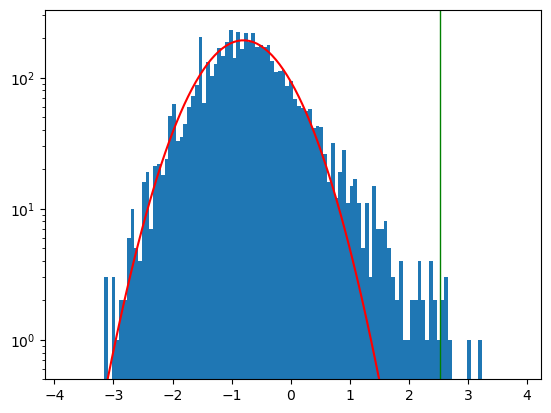

-0.8017334060780876 0.665403244053152 2.525282814187672
window 10
amp 262.2193475615876 mean -0.7420540551926958 stdev 0.4423312463288776


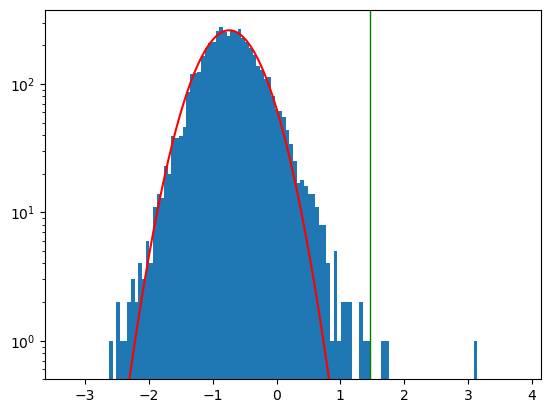

-0.7420540551926958 0.4423312463288776 1.4696021764516924
None
next: 127
next: 128
next: 129
window 5
amp 125.56502517009756 mean -0.15546802686253275 stdev 0.5704613083147498


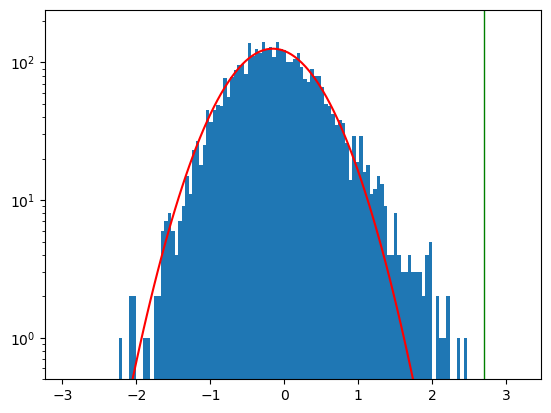

-0.15546802686253275 0.5704613083147498 2.6968385147112164
window 10
amp 193.02648939417182 mean -0.08787878767978893 stdev -0.3702763711581222


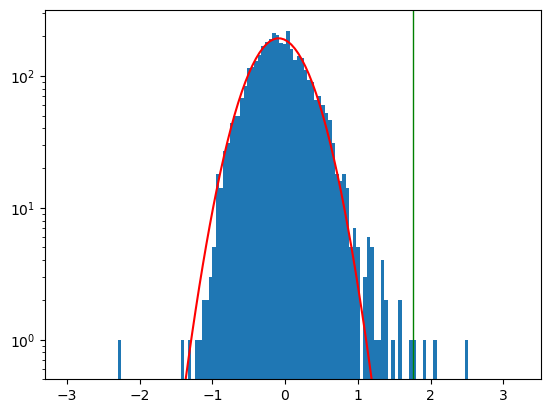

-0.08787878767978893 0.3702763711581222 1.763503068110822
None
next: 130
next: 131
next: 132
next: 133
next: 134
next: 135
next: 136
next: 137
next: 138
next: 139
next: 140
next: 141
next: 142
next: 143
next: 144
next: 145
next: 146
next: 147
next: 148
next: 149
next: 150
next: 151
next: 152
next: 153
next: 154
window 5
amp 146.5852820154469 mean -0.33920228294334603 stdev -0.6593207973138652


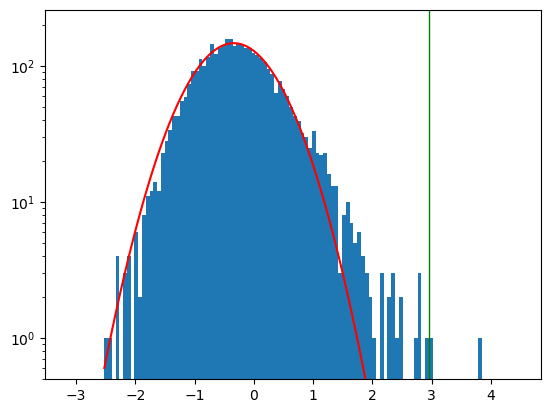

-0.33920228294334603 0.6593207973138652 2.95740170362598
window 10
amp 139.47546895620704 mean -0.29354033291545095 stdev 0.42768692662110247


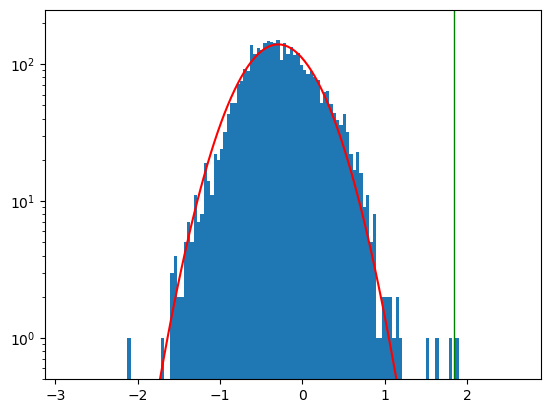

-0.29354033291545095 0.42768692662110247 1.8448943001900613
None
next: 155
window 5
amp 183.83084267316636 mean -0.7018945631399285 stdev -0.6245842424627692


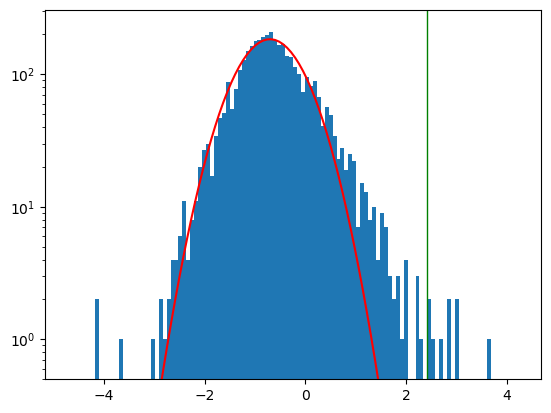

-0.7018945631399285 0.6245842424627692 2.4210266491739176
window 10
amp 135.6140614686954 mean -0.6311529216121456 stdev 0.4115029586984876


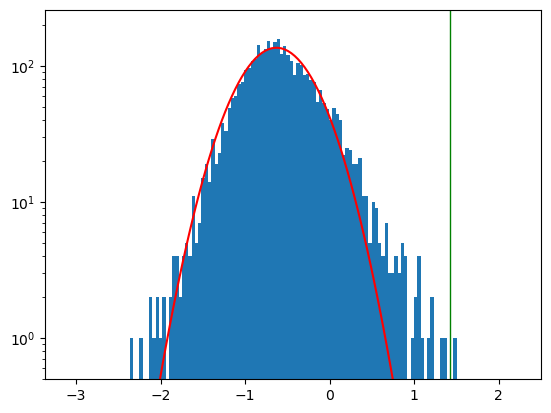

-0.6311529216121456 0.4115029586984876 1.4263618718802922
None
next: 156
next: 157
next: 158
next: 159
next: 160
next: 161
window 5
amp 210.35294133301397 mean -0.19930433614368126 stdev 0.600907474333731


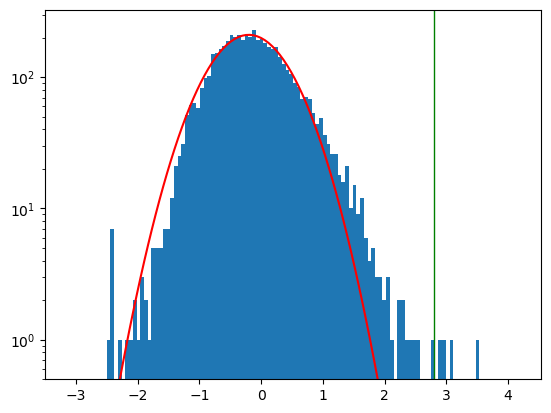

-0.19930433614368126 0.600907474333731 2.8052330355249735
window 10
amp 193.33346623936725 mean -0.12188102162961033 stdev 0.424809746441419


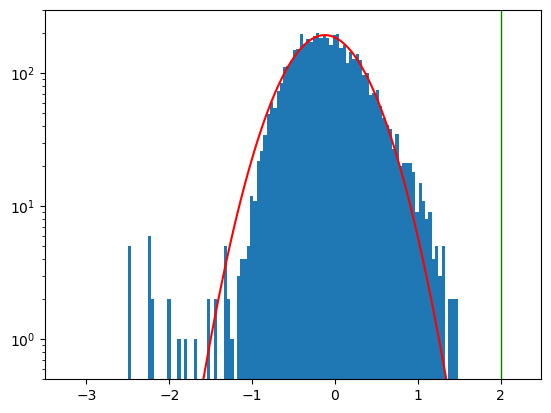

-0.12188102162961033 0.424809746441419 2.002167710577485
None
next: 162
next: 163
next: 164
next: 165
next: 166
next: 167
next: 168
next: 169
window 5
amp 281.88866054913035 mean -0.16417260332928763 stdev 0.5681360069325591


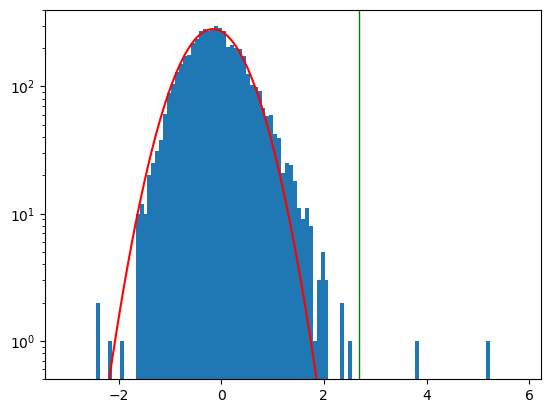

-0.16417260332928763 0.5681360069325591 2.6765074313335075
window 10
amp 229.5979052449136 mean -0.07211216155773018 stdev 0.3857478836033451


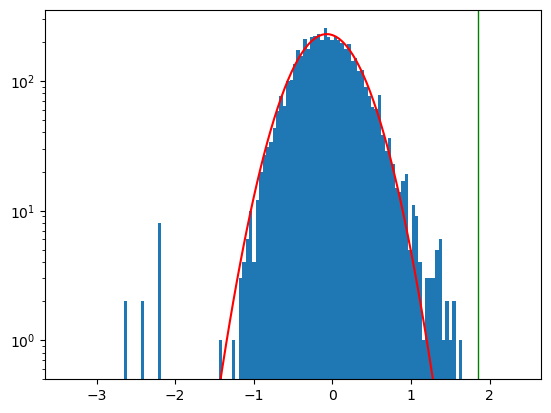

-0.07211216155773018 0.3857478836033451 1.8566272564589952
None
next: 170
window 5
amp 175.1921525659511 mean -0.12783197085740294 stdev 0.5596806272251001


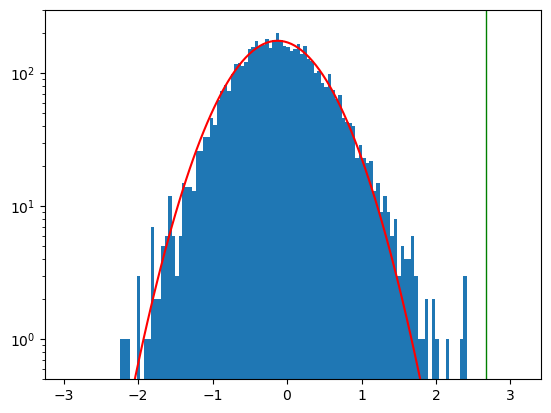

-0.12783197085740294 0.5596806272251001 2.6705711652680977
window 10
amp 237.20883041267248 mean -0.0025090990787359243 stdev 0.35656457473305553


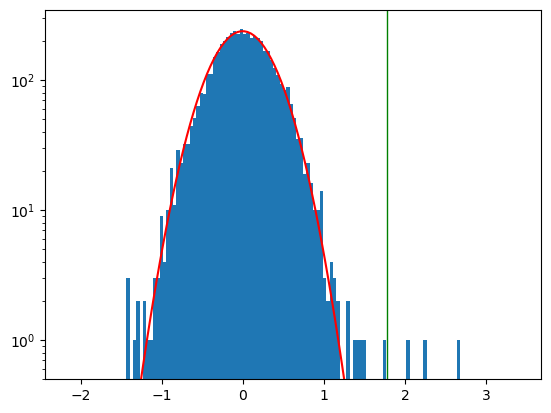

-0.0025090990787359243 0.35656457473305553 1.7803137745865416
None
next: 171
next: 172
next: 173
next: 174
next: 175
next: 176
next: 177
next: 178
next: 179
next: 180
next: 181
next: 182
next: 183
next: 184
next: 185
next: 186
next: 187
window 5
amp 60.296597104097785 mean -0.39068356270111304 stdev 0.6272482971220925


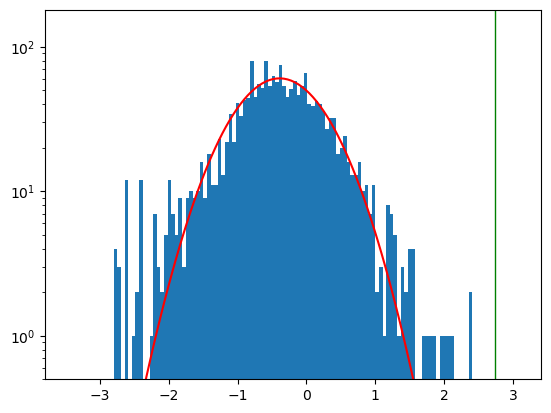

-0.39068356270111304 0.6272482971220925 2.7455579229093496
window 10
amp 75.3936005996454 mean -0.3203286033564838 stdev -0.48776888321153866


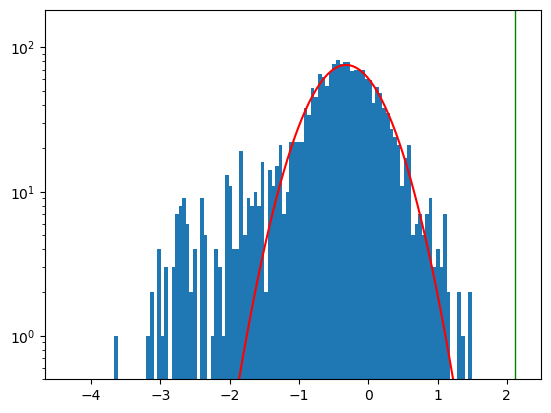

-0.3203286033564838 0.48776888321153866 2.1185158127012094
None
next: 188
next: 189
next: 190
next: 191
next: 192
next: 193
next: 194
next: 195
window 5
amp 117.4652868570257 mean -0.11611696834985388 stdev 0.5529648743610692


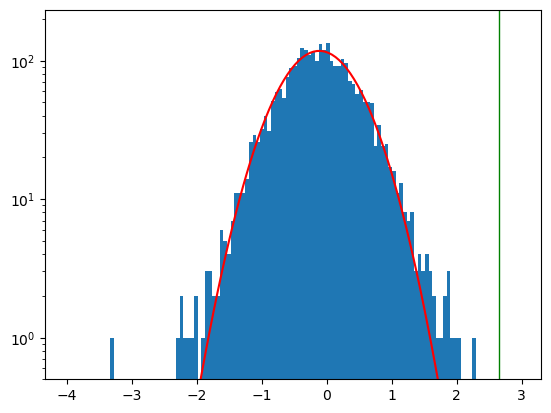

-0.11611696834985388 0.5529648743610692 2.648707403455492
window 10
amp 105.10607585603927 mean 0.0013382228693925781 stdev 0.3607241920623972


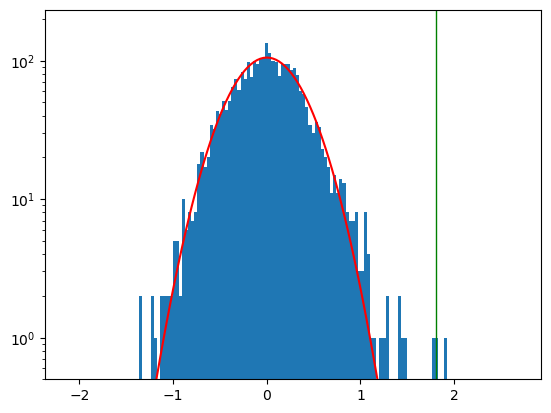

0.0013382228693925781 0.3607241920623972 1.8049591831813785
None
next: 196
next: 197
next: 198
next: 199
next: 200
next: 201
next: 202
next: 203
window 5
amp 200.9136936883918 mean -0.13287354051414757 stdev 0.556575087815307


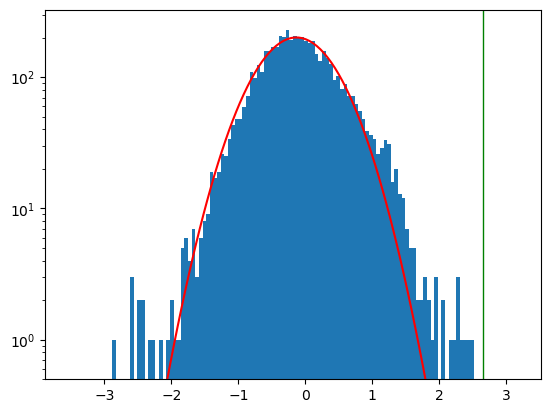

-0.13287354051414757 0.556575087815307 2.650001898562387
window 10
amp 232.26765087101674 mean -0.0031930501652270974 stdev 0.3997337074480206


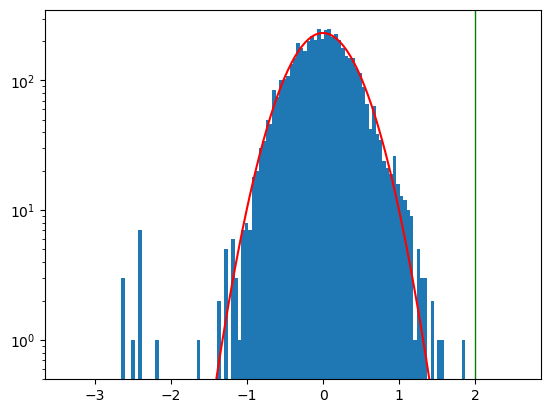

-0.0031930501652270974 0.3997337074480206 1.9954754870748759
None
next: 204
next: 205
next: 206
next: 207
next: 208
next: 209
next: 210
next: 211
window 5
amp 153.3862750157324 mean -1.2125493364795576 stdev 0.8096666682144787


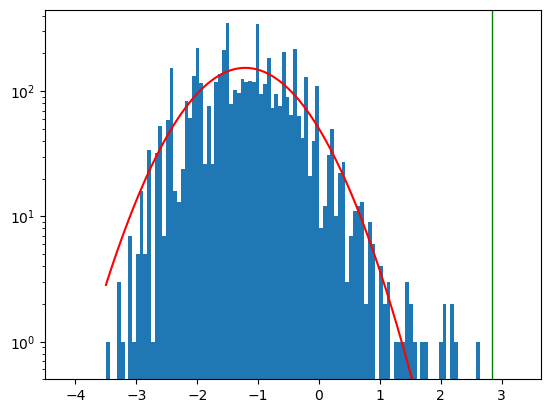

-1.2125493364795576 0.8096666682144787 2.835784004592836
window 10
amp 184.0454988458323 mean -1.2487462367437034 stdev -0.5600670431679774


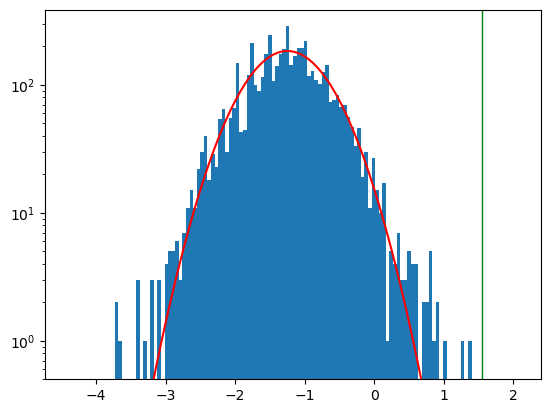

-1.2487462367437034 0.5600670431679774 1.5515889790961834
None
next: 212
next: 213
next: 214
next: 215
next: 216
next: 217
next: 218
next: 219
next: 220
next: 221
next: 222
next: 223
next: 224
next: 225
next: 226
next: 227
next: 228
window 5
amp 174.9250364261331 mean -1.2450692553436316 stdev 0.8273560380542587


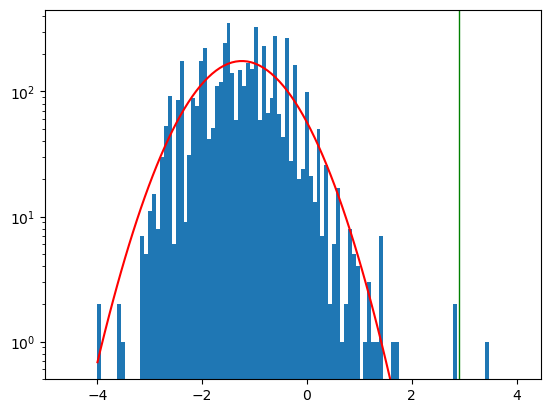

-1.2450692553436316 0.8273560380542587 2.891710934927662
window 10
amp 186.00430587072137 mean -1.337955599091755 stdev -0.5408129898888213


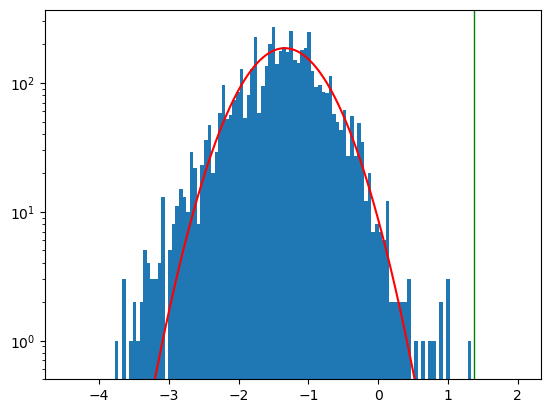

-1.337955599091755 0.5408129898888213 1.3661093503523516
None
next: 229
next: 230
next: 231
next: 232
next: 233
next: 234
next: 235
next: 236
next: 237
next: 238
next: 239
next: 240
next: 241
next: 242
next: 243
next: 244
next: 245
next: 246
window 5
amp 167.31275573780243 mean -1.3083271644627696 stdev -0.836062022889346


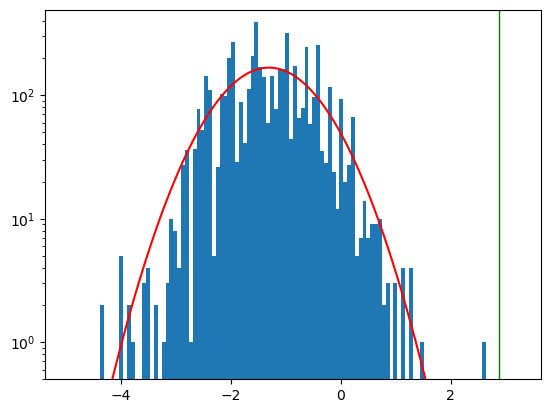

-1.3083271644627696 0.836062022889346 2.87198294998396
window 10
amp 194.1775209080091 mean -1.383169507095982 stdev -0.5542041171390789


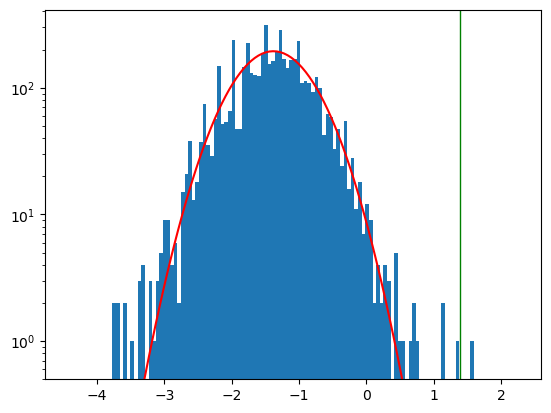

-1.383169507095982 0.5542041171390789 1.3878510785994125
None
next: 247
next: 248
next: 249
next: 250
next: 251
next: 252
window 5
amp 186.507043769838 mean -0.22598015210893502 stdev 0.5463171038919564


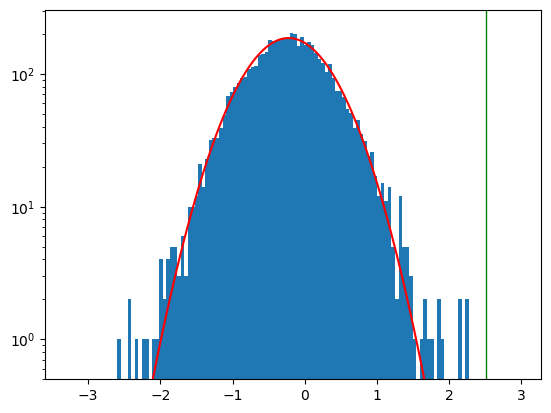

-0.22598015210893502 0.5463171038919564 2.505605367350847
window 10
amp 237.2337168896838 mean 0.01049070317567666 stdev 0.3787560702528067


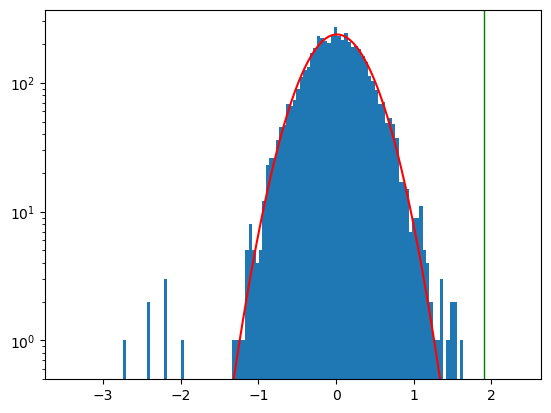

0.01049070317567666 0.3787560702528067 1.9042710544397103
None
next: 253
next: 254
next: 255
next: 256
next: 257
next: 258
window 5
amp 197.94582874315475 mean -0.14293779332701573 stdev 0.549274655172963


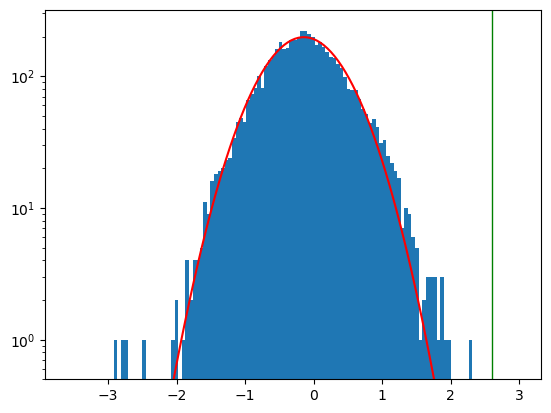

-0.14293779332701573 0.549274655172963 2.603435482537799
window 10
amp 293.9662055108522 mean 0.0020489302815788297 stdev 0.37536453576484363


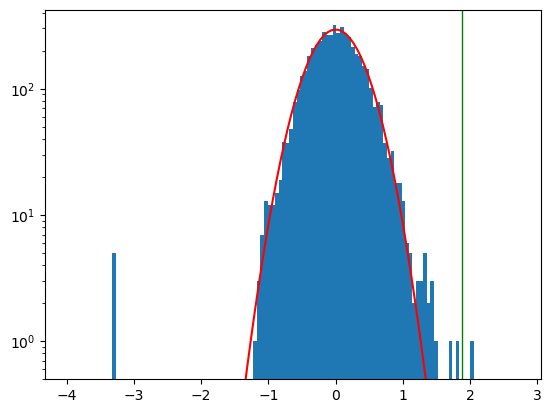

0.0020489302815788297 0.37536453576484363 1.878871609105797
None
next: 259
next: 260
next: 261
next: 262
window 5
amp 192.9636099788432 mean -1.0716136582655187 stdev 0.721896566221917


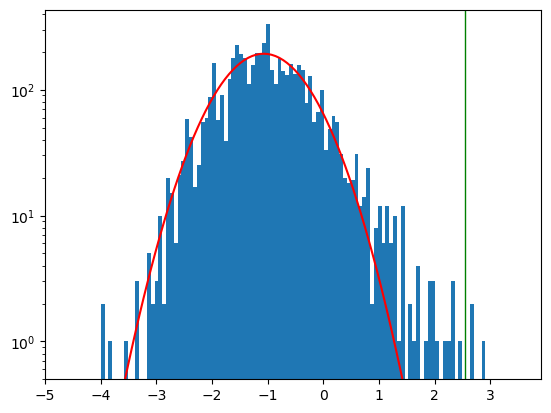

-1.0716136582655187 0.721896566221917 2.5378691728440663
window 10
amp 233.15246639693072 mean -1.0141803435173014 stdev 0.4688577880316293


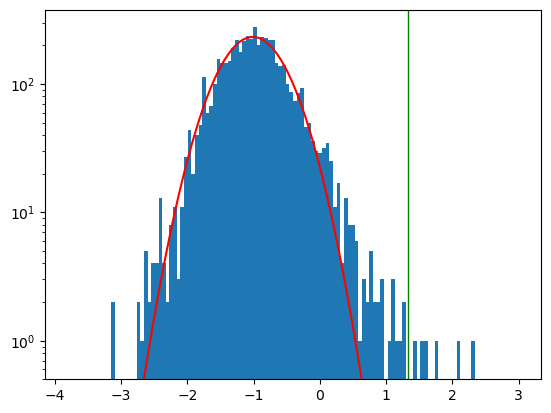

-1.0141803435173014 0.4688577880316293 1.3301085966408452
None
next: 263
next: 264
next: 265
next: 266
next: 267
next: 268
next: 269
next: 270
next: 271
next: 272
next: 273
next: 274
next: 275
next: 276
window 5
amp 193.53747331723815 mean -1.0881250278642507 stdev 0.7478972804206595


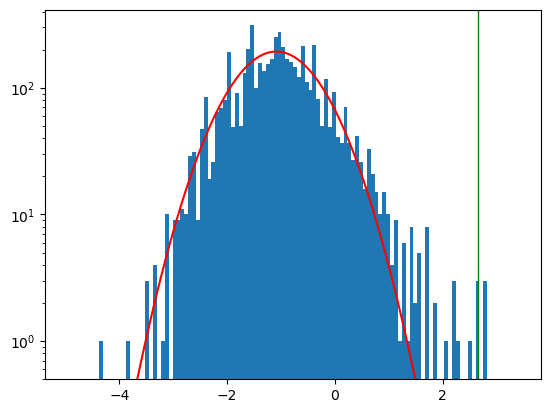

-1.0881250278642507 0.7478972804206595 2.651361374239047
window 10
amp 185.30386645040684 mean -1.0372974434728635 stdev 0.4990461449400799


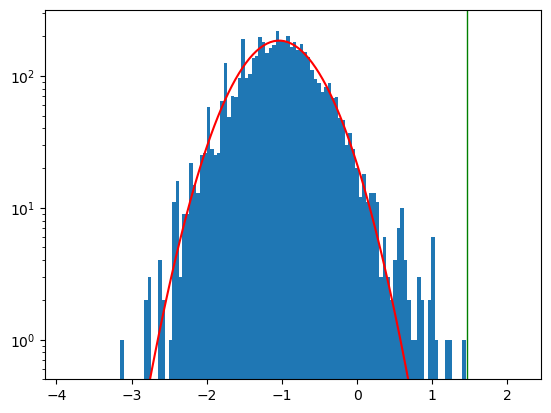

-1.0372974434728635 0.4990461449400799 1.457933281227536
None
next: 277
next: 278
next: 279
next: 280
next: 281
next: 282
next: 283
next: 284
next: 285
next: 286
next: 287
window 5
amp 266.679319636685 mean -1.0235004144639808 stdev 0.7195501702843297


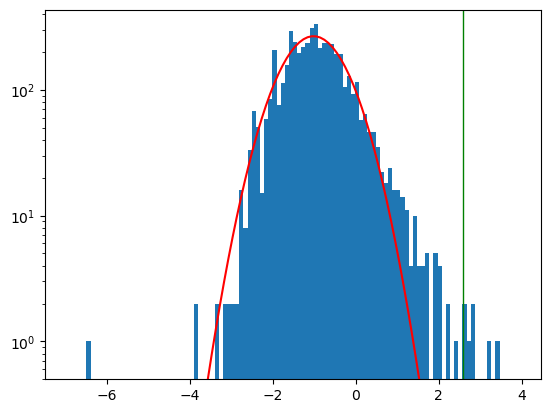

-1.0235004144639808 0.7195501702843297 2.5742504369576675
window 10
amp 176.30569107085176 mean -0.9980327277989337 stdev 0.4908246632607559


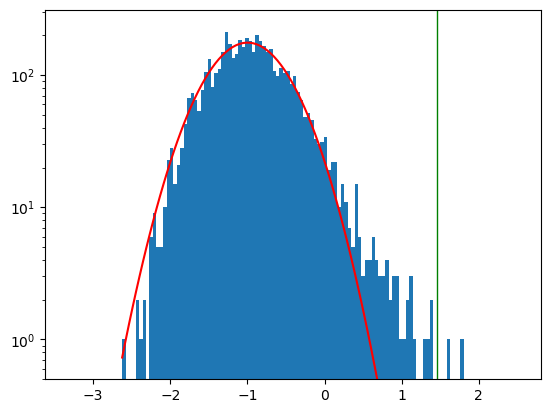

-0.9980327277989337 0.4908246632607559 1.4560905885048459
None
next: 288
next: 289
next: 290
next: 291
next: 292
next: 293
next: 294
next: 295
next: 296
window 5
amp 245.90121922316897 mean -0.23760358243719076 stdev 0.5484136344153966


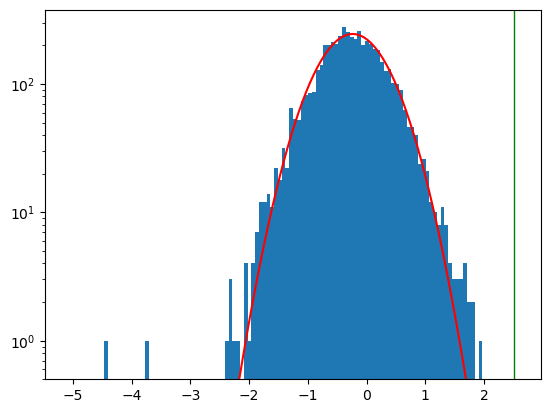

-0.23760358243719076 0.5484136344153966 2.504464589639792
window 10
amp 160.31278627799009 mean -0.0013130038895400602 stdev 0.384996484830496


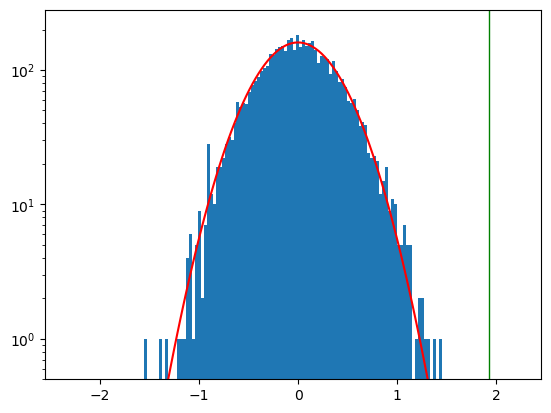

-0.0013130038895400602 0.384996484830496 1.9236694202629396
None
next: 297
next: 298
next: 299
next: 300
next: 301
next: 302
window 5
amp 47.23602215664279 mean -0.14888525723649795 stdev -0.5666943682240031


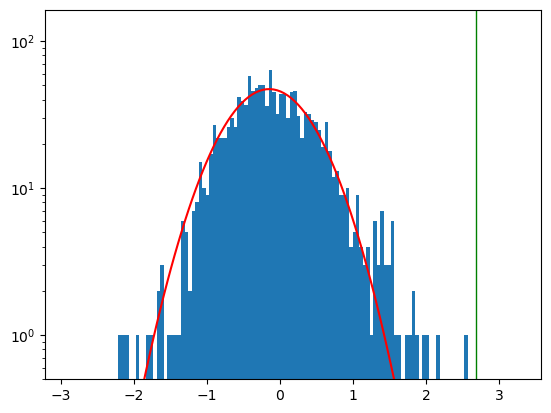

-0.14888525723649795 0.5666943682240031 2.684586583883518
window 10
amp 40.08370069004039 mean -0.0569865320613884 stdev 0.3537185531054184


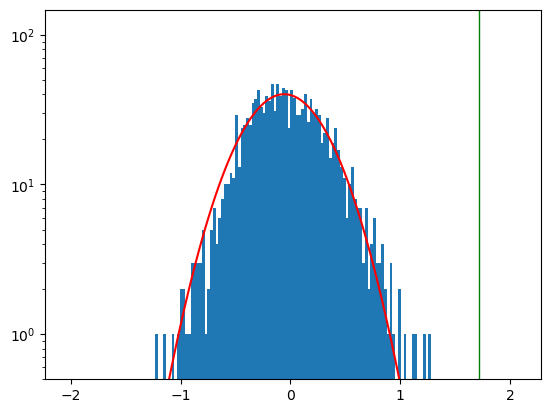

-0.0569865320613884 0.3537185531054184 1.7116062334657034
None
next: 303
next: 304
next: 305
next: 306
next: 307
next: 308
next: 309
next: 310
next: 311
next: 312
next: 313
window 5
amp 190.34672382338215 mean -0.13585224196647927 stdev 0.5758645294884007


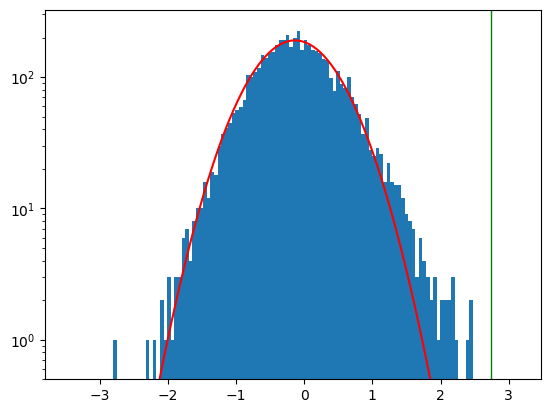

-0.13585224196647927 0.5758645294884007 2.7434704054755246
window 10
amp 174.7116986369865 mean -0.0705077945340098 stdev 0.39625934914561284


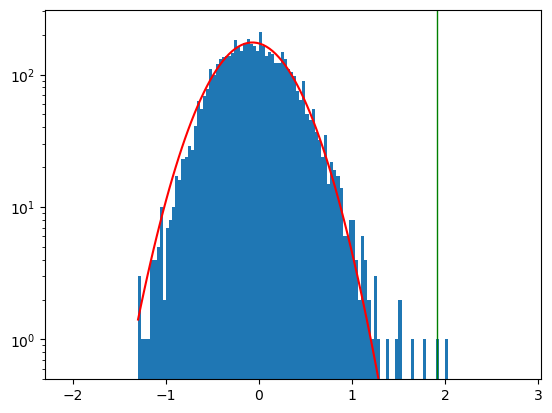

-0.0705077945340098 0.39625934914561284 1.9107889511940543
None
next: 314
next: 315
window 5
amp 203.36942915956175 mean -0.10481685806899049 stdev -0.5477618818976525


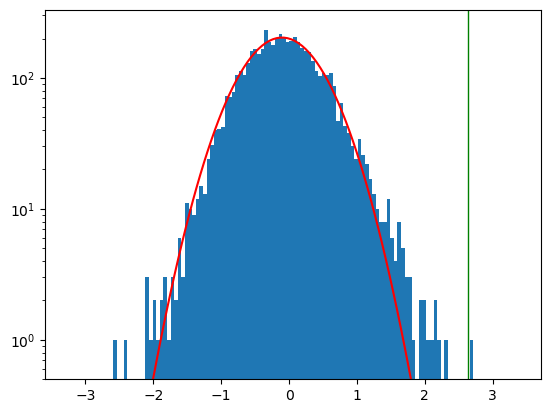

-0.10481685806899049 0.5477618818976525 2.633992551419272
window 10
amp 266.0078870585807 mean -0.023780230184642884 stdev 0.3699383699307089


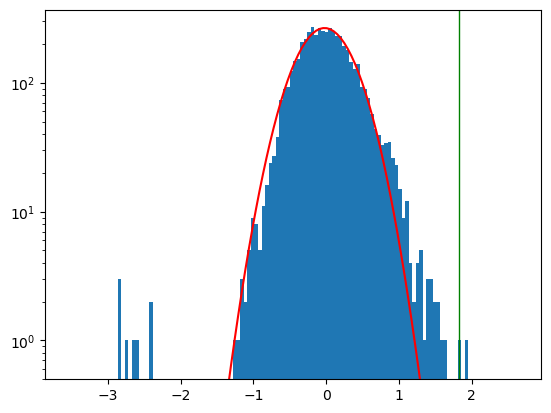

-0.023780230184642884 0.3699383699307089 1.8259116194689016
None
next: 316
next: 317
next: 318
next: 319
next: 320
next: 321
next: 322
next: 323
next: 324
next: 325
next: 326
window 5
amp 106.5014716717561 mean -0.6146839853589845 stdev -0.6287631207171991


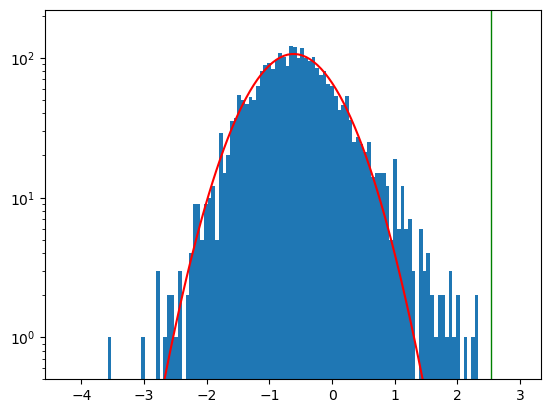

-0.6146839853589845 0.6287631207171991 2.529131618227011
window 10
amp 80.70485106689983 mean -0.5768305948304785 stdev 0.4504386889742011


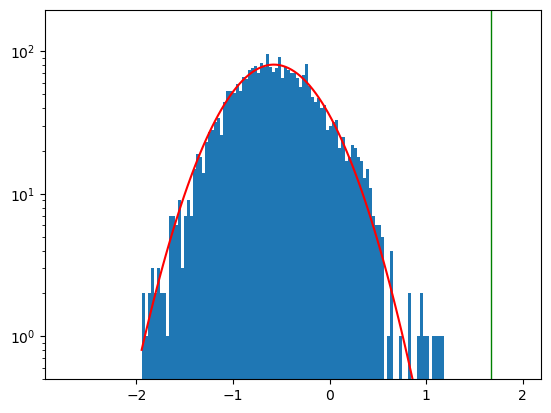

-0.5768305948304785 0.4504386889742011 1.675362850040527
None
next: 327
next: 328
next: 329
next: 330
next: 331
next: 332
next: 333
window 5
amp 148.71663277944756 mean -0.2678974581844646 stdev 0.5853306813940465


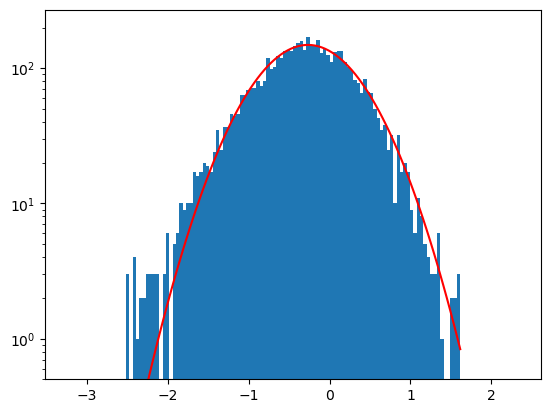

-0.2678974581844646 0.5853306813940465 2.658755948785768
window 10
amp 406.4826148505101 mean 0.04955490653349951 stdev 0.39045475738976293


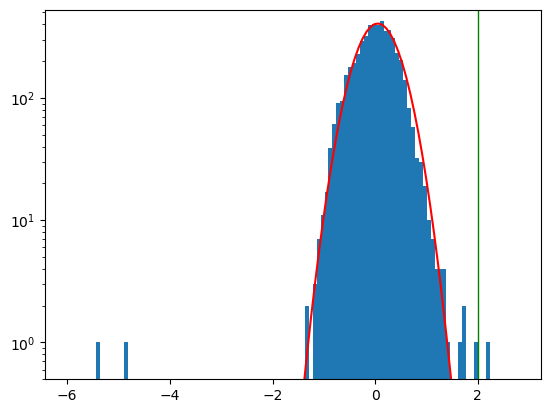

0.04955490653349951 0.39045475738976293 2.0018286934823144
None
next: 334
window 5
amp 279.98934390889184 mean -0.8354226532932949 stdev 0.6655473411977799


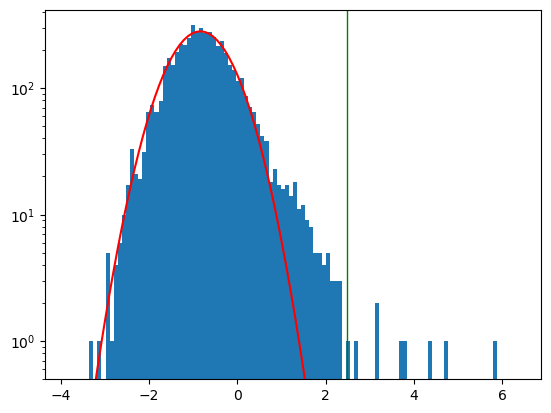

-0.8354226532932949 0.6655473411977799 2.4923140526956047
window 10
amp 167.38120136082046 mean -0.7599323323174274 stdev 0.487990387822505


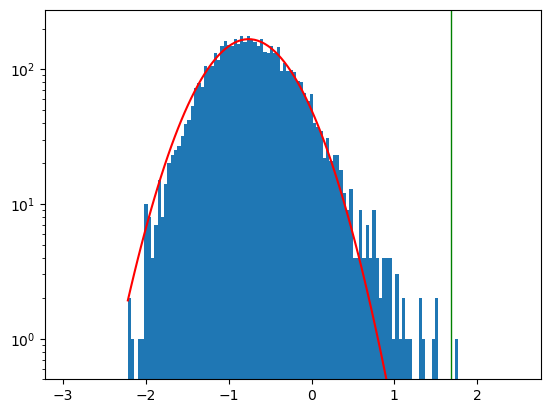

-0.7599323323174274 0.487990387822505 1.6800196067950974
None
next: 335
next: 336
next: 337
window 5
amp 97.08522573566948 mean -0.1891723330392315 stdev -0.5942370700083668


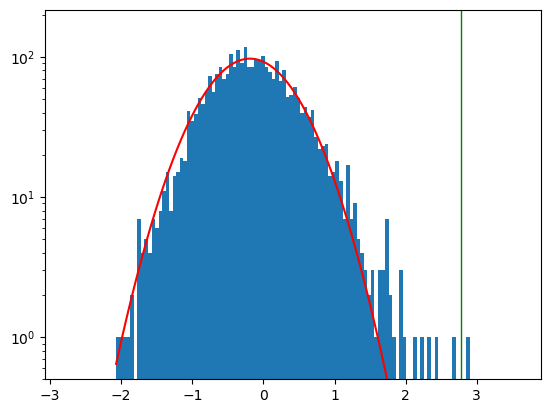

-0.1891723330392315 0.5942370700083668 2.7820130170026025
window 10
amp 89.43623547238397 mean -0.12931438305514237 stdev 0.36438238380722543


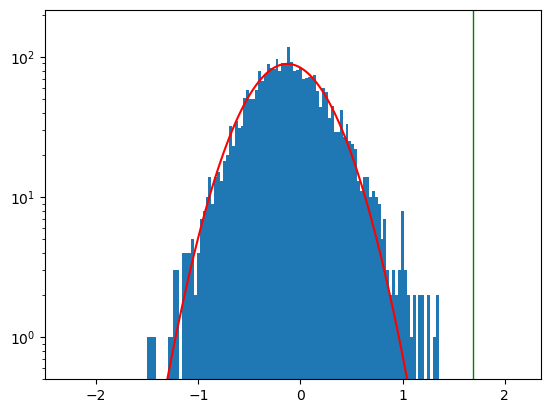

-0.12931438305514237 0.36438238380722543 1.6925975359809848
None
next: 338
next: 339
next: 340
next: 341
next: 342
next: 343
next: 344
next: 345
next: 346
next: 347
next: 348
next: 349
next: 350
window 5
amp 212.0391381577604 mean -1.0854927777500312 stdev 0.6938283888504209


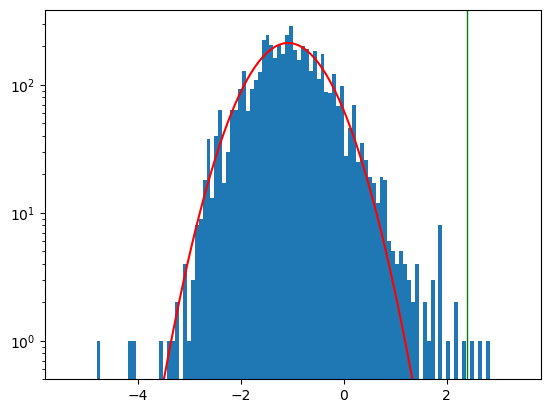

-1.0854927777500312 0.6938283888504209 2.3836491665020736
window 10
amp 161.44242815925932 mean -1.023805635992783 stdev -0.4706489453652245


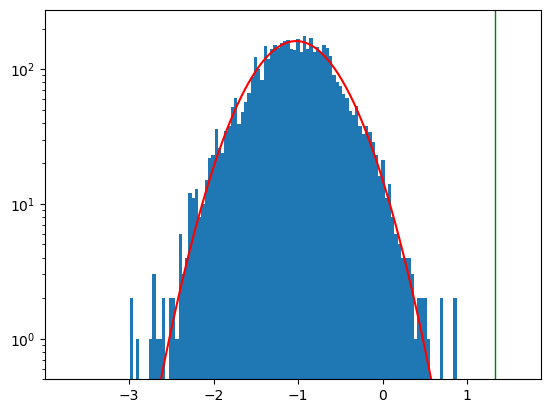

-1.023805635992783 0.4706489453652245 1.3294390908333396
None
next: 351
next: 352
next: 353
next: 354
next: 355
next: 356
next: 357
next: 358
next: 359
next: 360
next: 361
next: 362
next: 363
next: 364
next: 365
next: 366
next: 367
next: 368
next: 369
next: 370
next: 371
next: 372
next: 373
next: 374
next: 375
next: 376
next: 377
next: 378
next: 379
window 5
amp 122.95773148879128 mean -0.4700680312887881 stdev -0.6336871572083319


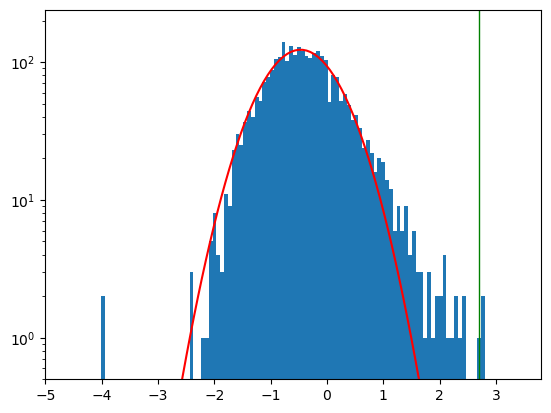

-0.4700680312887881 0.6336871572083319 2.6983677547528715
window 10
amp 113.48500272116372 mean -0.4270227433245245 stdev 0.44071950232671403


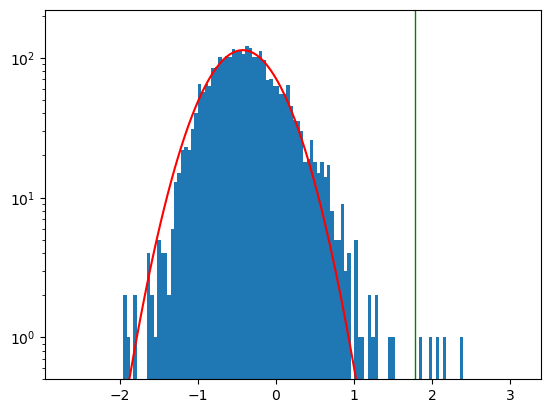

-0.4270227433245245 0.44071950232671403 1.7765747683090454
None
next: 380
next: 381
next: 382
next: 383
next: 384
next: 385
next: 386
next: 387
next: 388
next: 389
next: 390
next: 391
next: 392
next: 393
window 5
amp 43.091137345320476 mean -0.11968835687729194 stdev 0.5679041074959418


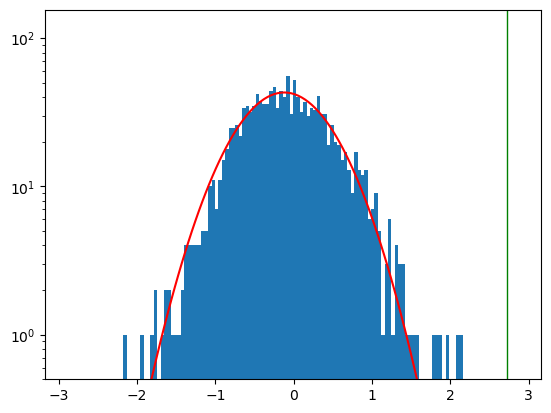

-0.11968835687729194 0.5679041074959418 2.7198321806024173
window 10
amp 44.00695297139384 mean -0.011222884385819882 stdev 0.3893005434826105


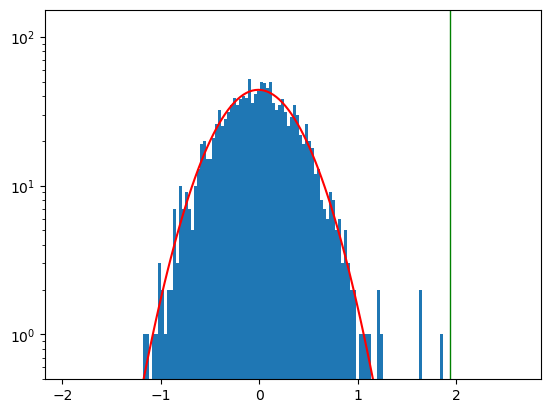

-0.011222884385819882 0.3893005434826105 1.9352798330272325
None
next: 394
next: 395
next: 396
next: 397
next: 398
next: 399
next: 400
next: 401


In [668]:
## getting stars with substantial data

print('analyzing stars...')

for i in range(len(stars)):
    starData = getData(stars[i])
    if (len(starData) >= 3000):
        starTimes = starData['TIME']

        ## bin star data
        binnedStarData = binStarData(starTimes)
        
        windows = analyzeStar(binnedStarData)

        ## print(windows) TODO

## Sanity Checks

In [73]:
starList.getStarByCoord(600, 600, 100)

star 18 at [589, 592] with snr 5.5345907961974214
star 97 at [678, 676] with snr 5.917974305856533
star 225 at [515, 520] with snr 6.019133751515567
star 226 at [516, 687] with snr 10.694395906478723
star 233 at [519, 665] with snr 7.365389205889152
star 236 at [525, 577] with snr 9.625762319486515
star 240 at [531, 565] with snr 9.435958984180624
star 251 at [541, 661] with snr 5.25015916394751
star 253 at [546, 680] with snr 7.4021469272821845
star 257 at [551, 684] with snr 5.8221818463771955
star 261 at [562, 552] with snr 6.041194094221617
star 262 at [568, 500] with snr 16.00223665097435
star 263 at [567, 651] with snr 6.183520513254581
star 269 at [578, 656] with snr 6.86293247982395
star 272 at [581, 562] with snr 7.76237464405493
star 273 at [581, 608] with snr 11.238874844765169
star 284 at [590, 652] with snr 6.109027954523981
star 285 at [596, 575] with snr 9.699474607297615
star 289 at [603, 631] with snr 5.596397515405933
star 290 at [605, 615] with snr 9.013728391996471


620 578


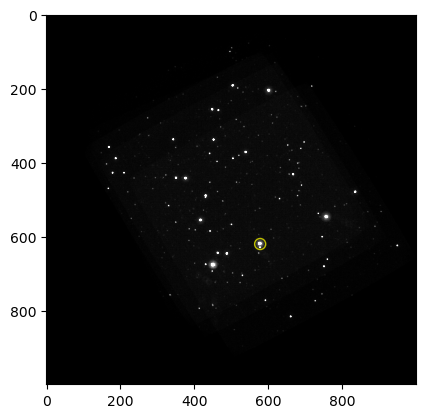

In [74]:
starList.displayStar(296, mode='whole')

getting star data...


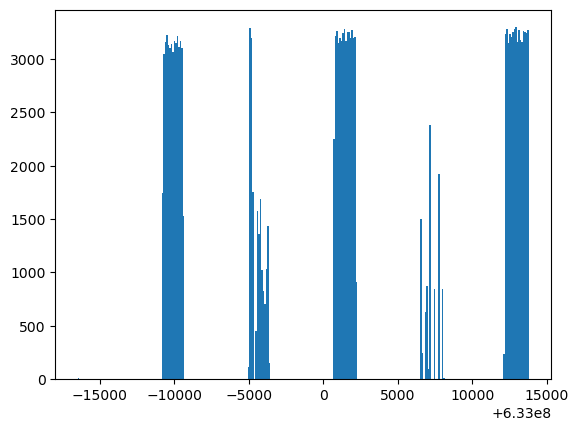

In [75]:
timeData = getData(stars[296])
plt.hist(timeData['TIME'], bins=300)
plt.show()

In [76]:
starData = binStarData(timeData['TIME'])

binning star data...


Text(0.5, 1.0, 'Binned Photon Events for YZ CMi')

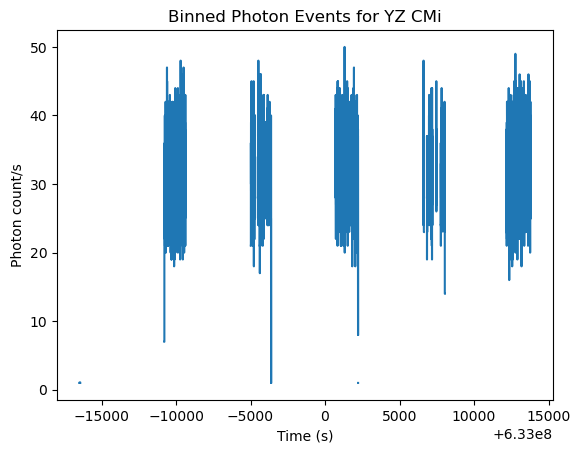

In [77]:
plt.step(starData['time_bin_start'].value, starData['num_events'].value)
plt.xlabel('Time (s)')
plt.ylabel('Photon count/s')
plt.title('Binned Photon Events for YZ CMi')

In [1096]:
r, mt = getSignals(10, starData, False)

amp 281.2357694041966 mean -0.13078560173891435 stdev 0.40695619097699376


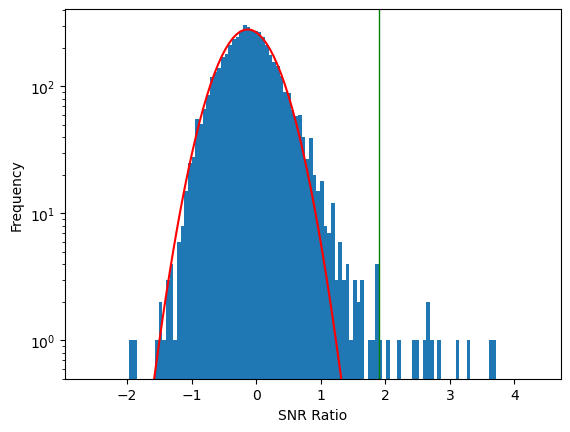

(-0.13078560173891435, 0.40695619097699376, 1.9039953531460545)

In [1097]:
visualizeSignals(r, 100)

In [1098]:
unusualSignalInfo(r, mt, 2, False)

index 2016 with ratio 2.223472850082071 at time 633000881.40076
index 2017 with ratio 2.646319224981265 at time 633000882.40076
index 2018 with ratio 2.828978401798995 at time 633000883.40076
index 2019 with ratio 3.1383305795452903 at time 633000884.40076
index 2020 with ratio 3.2840908949837724 at time 633000885.40076
index 2021 with ratio 3.624054180552141 at time 633000886.40076
index 2022 with ratio 3.714250440808664 at time 633000887.40076
index 2023 with ratio 2.723715824044152 at time 633000888.40076
index 4025 with ratio 2.513201719474712 at time 633012675.40076
index 4026 with ratio 2.6223156778309016 at time 633012676.40076
index 4027 with ratio 2.674274855692108 at time 633012677.40076
index 4028 with ratio 2.445211927797089 at time 633012678.40076
index 4029 with ratio 2.01057673510632 at time 633012679.40076


In [949]:
analyzeStar(starData) 

window 5


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78de48196c00>>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [1050]:
print('ratio', calculateRatio(10, 632990263.42296, starData, True))

bgEvents [38 37 43 36 38 40 37 40 43 44 37 36 39 47 38 37 36 41 45 42 42 42 41 41
 40 36 39 43 38 40]
signalCounts 463 signalArea 10
bgCounts 1196 bgArea 30
bgMeanRate 39.86666666666667 signalRate 6.43333333333333 totalNoiseRate 2.8836705005176224
ratio 2.2309529927842098


visualizing time series...


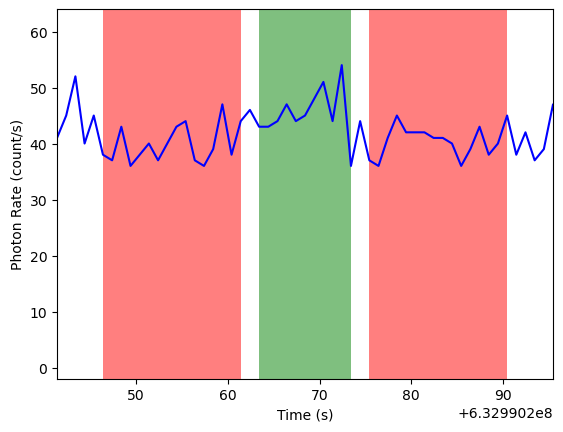

 time_bin_start time_bin_size num_events
                      s                 
--------------- ------------- ----------
632990241.42296           1.0         41
632990242.42296           1.0         45
632990243.42296           1.0         52
632990244.42296           1.0         40
632990245.42296           1.0         45
632990246.42296           1.0         38
            ...           ...        ...
632990289.42296           1.0         40
632990290.42296           1.0         45
632990291.42296           1.0         38
632990292.42296           1.0         42
632990293.42296           1.0         37
632990294.42296           1.0         39
632990295.42296           1.0         47
Length = 55 rows


In [1051]:
print(visualizeStarTS(starData, windowStart=632990263.42296, windowSize=10, point=False))

visualizing time series...


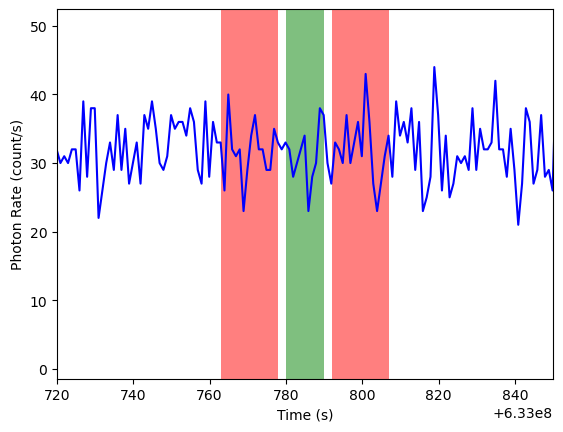

 time_bin_start time_bin_size num_events
                      s                 
--------------- ------------- ----------
633000720.88652           1.0         30
633000721.88652           1.0         31
633000722.88652           1.0         30
633000723.88652           1.0         32
633000724.88652           1.0         32
633000725.88652           1.0         26
            ...           ...        ...
633000843.88652           1.0         36
633000844.88652           1.0         27
633000845.88652           1.0         29
633000846.88652           1.0         37
633000847.88652           1.0         28
633000848.88652           1.0         29
633000849.88652           1.0         26
Length = 130 rows


In [90]:
print(visualizeStarTS(starData, customLim=True, xmin=633000720, xmax=633000850, windowStart=633000780, windowSize=10, point=False))